# Trabajo Práctico 2: Enunciado 

El segundo TP es una competencia de Machine Learning en donde cada grupo debe intentar determinar, para cada tweet brindado, si el mismo esta basado en un hecho real o no.

La competencia se desarrolla en la plataforma de Kaggle  https://www.kaggle.com/c/nlp-getting-started.  

El dataset consta de una serie de tweets, para los cuales se informa:

<br/>

* id - identificador unico para cada  tweet
* text - el texto del tweet
* location - ubicación desde donde fue enviado (podría no estar)
* keyword - un keyword para el tweet  (podría faltar)
* target - en train.csv, indica si se trata de un desastre real  (1) o no (0)
 
<br/><br/>


Los submits con el resultado deben tener el formato:

Id: Un id numérico para identificar el tweet
target: 1 / 0 según se crea que el tweet se trata sobre un desastre real, o no.

Los grupos deberán probar distintos algoritmos de Machine Learning para intentar predecir si el tweet está basado en hechos reales o no. A medida que los grupos realicen pruebas deben realizar el correspondiente submit en Kaggle para evaluar el resultado de los mismos.

Al finalizar la competencia el grupo que mejor resultado tenga obtendrá 10 puntos para cada uno de sus integrantes que podrán ser usados en el examen por promoción o segundo recuperatorio.

Requisitos para la entrega del TP2:

- El TP debe programarse en Python o R.
- Debe entregarse un pdf con el informe de algoritmos probados, algoritmo final utilizado, transformaciones realizadas a los datos, feature engineering, etc. 
- El informe debe incluir también un link a github con el informe presentado en pdf, y todo el código.
- El grupo debe presentar el TP en una computadora en la fecha indicada por la cátedra, el TP debe correr en un lapso de tiempo razonable (inferior a 1 hora) y generar un submission válido que iguale el mejor resultado obtenido por el grupo en Kaggle. (mas detalles a definir)

El TP2 se va a evaluar en función del siguiente criterio:

- Cantidad de trabajo (esfuerzo) del grupo: ¿Probaron muchos algoritmos? ¿Hicieron un buen trabajo de pre-procesamiento de los datos y feature engineering?
- Resultado obtenido en Kaggle (obviamente cuanto mejor resultado mejor nota)
- Presentación final del informe, calidad de la redacción, uso de información obtenida en el TP1, conclusiones presentadas.
- Performance de la solución final.


# 1. Preprocesado
#### Introducción 
Se levantan los datos como en el TP1. Sin EDA, solo el preprocesado del texto.

### 1.1 Instalación de librerias 

In [1]:
!pip3 install nltk
!pip3 install stopwords
!pip3 install gensim

!pip3 install sklearn
!pip3 install xgboost==0.7.post4

!pip3 install tensorflow
!pip3 install tensorflow_hub
!pip3 install "tqdm>=4.46.0"


### 1.2 Importación de librerías

In [2]:
import pandas as pd
import numpy as np

import warnings
import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn import model_selection

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron
from sklearn.metrics import f1_score,roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA, TruncatedSVD

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from time import process_time

import tensorflow_hub as hub 
import tensorflow as tf 

from tqdm.notebook import tqdm 
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alejandro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alejandro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alejandro/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alejandro/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alejandro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 1.3 Obtención de datos
Lectura de datos de entrenamiento y test.

In [4]:
tweets_train = pd.read_csv('../data/train.csv', encoding='utf-8')
tweets_test = pd.read_csv('../data/test.csv', encoding='utf-8')

### 1.4 Limpieza de datos.
#### Introducción
Antes de empezar, hay que normalizar el texto ya que luego de la tokenización serán convertidos en vectores dentro de una matriz, las técnicas a utilizar:
* **Uppercase/lowercase**: Paso todo a lower/upper case, ya que una misma palabra tiene una representación distinta si se hay un cambio de mayúscula minúscula.
* **Limpieza de texto**: Signos de puntuación, valores numéricos, links, carácteres especiales, etc.
* **Tokenizacion**: Es el proceso de convertir el texto en una lista de tokens,
* **Stopwords**: Elimino palabras comunes que no aportan información
* **Stemming**: Elimino los sufijos de palabras que puedan tener el mismo significado (o función dentro del texto)
* **Lemmatization**: Unifico palabras que signifiquen lo mismo en base a su definición del diccionario

Inicializo dataset para probar las funciones

In [5]:
#Copia de datasets para trabajar el pre-procesado de texto
train_df1 = tweets_train.copy()
test_df1  = tweets_test.copy()

#### 1.4.1 Uppercase + Limpieza de texto

In [6]:
#Funcion para eliminar emojis, viene del tp1
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

def remove_emojis_non_ascii(text):    
    #replace consecutive non-ASCII characters with a space
    result = re.sub(r'[^\x00-\x7F]+',' ', text)
    #remove emojis from tweet
    result = emoji_pattern.sub(r'', result)    
    return result


#Funcion para limpieza del texto (todo a LOWERCASE)
def text_clean(text):
    text = text.lower()
    text = remove_emojis_non_ascii(text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [7]:
#Aplico la funcion a la copia de los Dataset de entrenamiento y test
train_df1['text'] = train_df1['text'].apply(lambda x: text_clean(x))
test_df1['text'] = test_df1['text'].apply(lambda x: text_clean(x))

#### 1.4.2 Tokenización
_Probar los distintos que ofrece la librería nltk_

In [8]:
#Para tokenizar utilizo el RegEx tokenizer de nltk
#tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

#Para tokenizar utilizo WhitespaceTokenizer
#tokenizer = nltk.tokenize.WhitespaceTokenizer()

#Para tokenizar utilizo WordPunctTokenizer
#tokenizer = nltk.tokenize.WordPunctTokenizer()

#Para tokenizar utilizo TreebankWordTokenizer
self_tokenizer = nltk.tokenize.TreebankWordTokenizer()


In [9]:
train_df1['text'] = train_df1['text'].apply(lambda x: self_tokenizer.tokenize(x))
test_df1['text'] = test_df1['text'].apply(lambda x: self_tokenizer.tokenize(x))

#### 1.4.3 Stopwords

In [10]:
#Funcion para eliminar Stopwords
def text_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [11]:
train_df1['text'] = train_df1['text'].apply(lambda x : text_stopwords(x))
test_df1['text'] = test_df1['text'].apply(lambda x : text_stopwords(x))

#### 1.4.4 Stemming + Lemmatizing
Probar si aportan algo

In [12]:
# Funcion para Stemming y Lemmatizing
def text_stemming(text):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text)
    stemmer = nltk.stem.PorterStemmer()
    text_stemmed = " ".join(stemmer.stem(token) for token in tokens)
    return text_stemmed

def text_lemmatizing(text):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text)
    lemmatizer=nltk.stem.WordNetLemmatizer()
    text_lemmatized = " ".join(lemmatizer.lemmatize(token) for token in tokens)
    return text_lemmatized

In [13]:
#Combino el texto para luego de haberlo procesado
def text_combine(text):
    comb_text = ' '.join(text)
    return comb_text

In [14]:
train_df1['text'] = train_df1['text'].apply(lambda x : text_combine(x))
test_df1['text'] = test_df1['text'].apply(lambda x : text_combine(x))

In [15]:
test_df1.head() ##Datos Antes del lemmatizing

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


In [16]:
test_df1['text'] = test_df1['text'].apply(lambda x : text_lemmatizing(x))

In [17]:
test_df1.head() ##Datos luego del lemmatizing

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different city stay safe ever...
2,3,NaN,NaN,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfire
4,11,NaN,NaN,typhoon soudelor kill china taiwan


#### 1.4.5 Pre-procesado de texto
Devuelve texto, agregar una para devolver tambien solo TOKENS, ya que es lo que se va a utilizar para entrenar al modelo

In [18]:
def pre_process_text(text): 
    cleaned_txt = text_clean(text)
    lemma_text = text_lemmatizing(cleaned_txt)
    tokenized_text = self_tokenizer.tokenize(lemma_text)    
    remove_stopwords = text_stopwords(tokenized_text)
    combined_text = text_combine(remove_stopwords)
    return combined_text

In [19]:
test_df1['text'] = test_df1['text'].apply(lambda x : pre_process_text(x))
test_df1.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different city stay safe ever...
2,3,NaN,NaN,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfire
4,11,NaN,NaN,typhoon soudelor kill china taiwan


## 2. Preparacion de datasets
Preparo datasets de train y test aplicando el preprocesado.

### 2.1 Preprocesamiento de textos (campo text y keyword)

In [20]:
train_df2=tweets_train.copy()
train_df2['text'] = train_df2['text'].apply(lambda x : pre_process_text(x))
train_df2['keyword'] = train_df2['keyword'].apply(lambda x : pre_process_text(str(x)))

test_df2=tweets_test.copy()
test_df2['text'] = test_df2['text'].apply(lambda x : pre_process_text(x))
test_df2['keyword'] = test_df2['keyword'].apply(lambda x : pre_process_text(str(x)))

### 2.2 Eliminación de duplicados
Eliminamos las filas duplicadas en el set de entrenamiento que tengan un target diferente para evitar inconsistencias.

In [21]:
duplicated_rows_train = train_df2[train_df2.duplicated(['text'],keep=False)]
# de las duplicadas reviso cuales tienen target diferente
duplicated_groups = duplicated_rows_train.groupby('text', as_index=False).agg({'target':['sum',"count"]})
same_text_diff_target = duplicated_groups[(duplicated_groups['target']['sum'] != 0) & (duplicated_groups['target']['sum'] != duplicated_groups['target']['count'])]['text']
same_text_train_ids = duplicated_rows_train[duplicated_rows_train['text'].isin(same_text_diff_target)]['id']

# sacamos del train set los ids duplicados
train_df2 = train_df2.drop(train_df2[train_df2.id.isin(same_text_train_ids)].index)
# y del dataset original para evitar errores si se usa el target de ese set
tweets_train = tweets_train.drop(tweets_train[tweets_train.id.isin(same_text_train_ids)].index)
# Se eliminan unas 318 filas
tweets_train.shape 

(7295, 5)

### 2.3 Nuevo feature: Analisis de sentimientos
En el análisis previo pudimos observar que textos que resultan ser verdaderos suelen tener más sentimientos negativos que los que resultan falsos. Agregamos esta feature al dataset

In [22]:
# agrego feature de sentimiento
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
train_df2['sentiment_score'] = train_df2.text.apply(lambda x: sid.polarity_scores(x)['compound'])
test_df2['sentiment_score'] = test_df2.text.apply(lambda x: sid.polarity_scores(x)['compound'])

# 3. Vectorización del texto
Para entrenar el modelo necesitamos convertir el texto a una matriz de vectores para que pueda interpretarlo, 
para lograrlo existen distintas técnicas.

* Word2Vec
* Universal Sentence Encoder
* Bag of Words
* TF-IDF
* N-Gramas
* Feature Hashing

Cada una de estas alternativas esta directamente relacionada con la transformación del texto (Tokenizacion, limpieza, lemming, stemming)

Función para graficar (PCA) las distintas vectorizaciones

In [23]:
##Funcion interna
def plot_LSA(test_data, test_labels):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']        
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        orange_patch = mpatches.Patch(color='orange', label='Falso')
        blue_patch = mpatches.Patch(color='blue', label='Verdadero')
        plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})


list_text = train_df2["text"].tolist()
list_keyword = train_df2["keyword"].tolist()
list_labels = train_df2["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_text, list_labels, test_size=0.2, 
                                                                            random_state=32)            

##ultima funcion
##train_x es el array de la columna text, vectorizado
def Graph_vectorization(train_x,train_y,model_name):
    fig = plt.figure(figsize=(14, 14))          
    plot_LSA(train_x, train_y)
    #fig.suptitle(model_name)    
    plt.figtext(.5,.9,model_name, fontsize=30, ha='center')
    plt.show()


## 3.1 Word2Vec Embbeding

In [26]:
import gensim
import gensim.downloader as api

model = api.load("glove-twitter-200")  # download the model and return as object ready for use

In [27]:
# http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec, dimentions):
        self.word2vec = word2vec
        # dimension del vector
        self.dim = dimentions

    def fit(self, X, y):
        return self

    def transform(self, X):
        # tranformación: se busca la palabra en el modelo de w2vec, si no existe se llena con ceros el vector
        # se calcula el promedio para el vector final
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [28]:
from collections import defaultdict

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec, dimentions):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = dimentions

    def fit(self, X):
        # TODO ver si estos parametros estan OK
        tfidf = TfidfVectorizer(analyzer=lambda x: x,min_df=2, max_df=0.5, ngram_range=(2, 3))
        tfidf.fit(X)
        # Se calcula el "peso" de cada palabra: 
        # usando el mayor valor de tf-idf 
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w] for w in words if w in self.word2vec]
                        or [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [29]:
# armamos el diccionario de w2vec
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [30]:
meanEmbedding = MeanEmbeddingVectorizer(w2v, model.vector_size)
train_w2vec = meanEmbedding.transform(train_df2.text)
test_w2vec = meanEmbedding.transform(test_df2.text)

In [31]:
tfidfEmbedding = TfidfEmbeddingVectorizer(w2v, model.vector_size)
train_w2vecTfid = tfidfEmbedding.fit(train_df2.text).transform(train_df2.text)
test_w2vecTfid = tfidfEmbedding.transform(test_df2.text)

#### 3.1.1 Gráfico MeanEmbedding

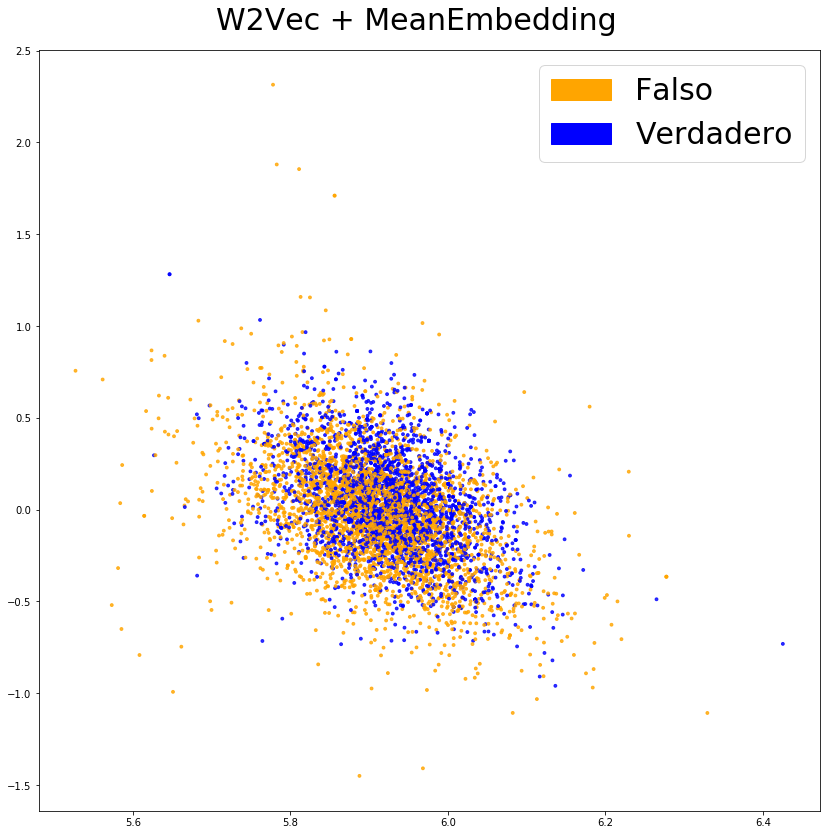

In [32]:
graph_w2vec_x = meanEmbedding.transform(X_train)
Graph_vectorization(graph_w2vec_x,y_train,"W2Vec + MeanEmbedding")

#### 3.1.2 Gráfico (TF-IDF) Embedding

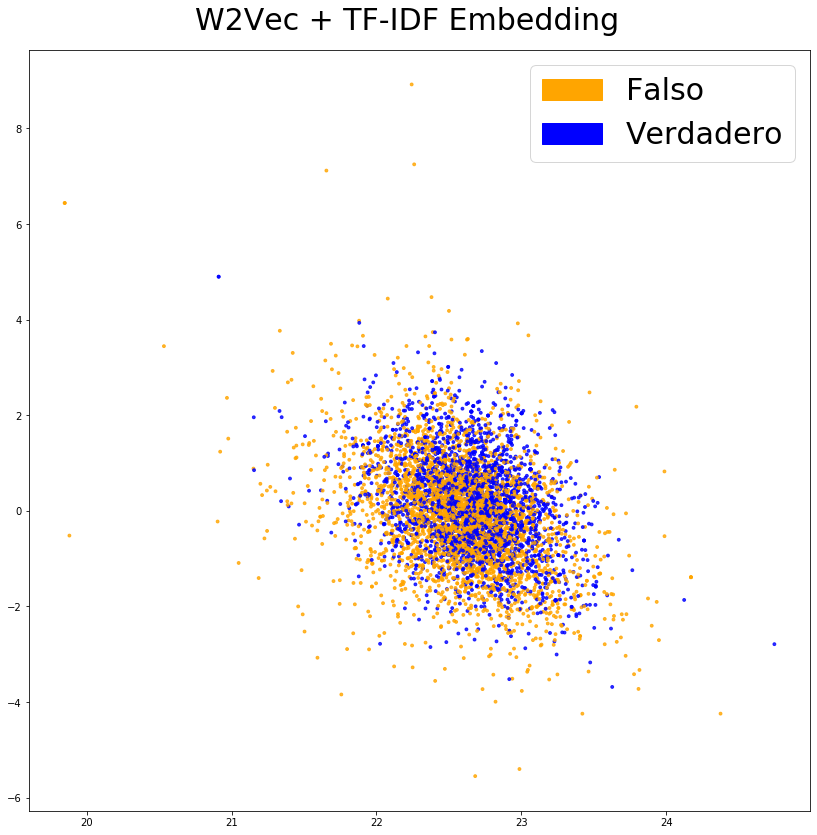

In [33]:
graph_w2vecTF_x = tfidfEmbedding.transform(X_train)
Graph_vectorization(graph_w2vecTF_x,y_train,"W2Vec + TF-IDF Embedding")

## 3.2 Universal Sentence Encoder (tensorflow)

USE (Universal sentence encoder) cifra el texto en vectores de alta dimensión que pueden ser utilizados en clasificación, similaridad semántica y clustering. El modelo es óptimo para textos grandes, como por ejemplo: oraciones, frases o parágrafos cortos.

In [34]:
large_use = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
embed = hub.load(large_use)
    
def transfrom(text_train, text_test):    
    vector_train = [tf.reshape(embed([line]), [-1]).numpy() for line in tqdm(text_train)]
    vector_test = [tf.reshape(embed([line]), [-1]).numpy() for line in tqdm(text_test)]

    return vector_train, vector_test
    

paso el texto a vectores, Lo hago con la columna **texto** y la columna **keyword**

In [35]:
train_use_tf, test_use_tf = transfrom(train_df2.text, test_df2.text)
train_use_tf_k, test_use_tf_k = transfrom(train_df2.keyword, test_df2.keyword)

#### 3.2.1 Gráfico Universal-Sentence-Encoder

In [36]:
#Grafico vectorizacion
graph_useftx, _dummy = transfrom(X_train, X_train)


## 3.3 Bag of Words
Se crea un diccionario de palabras conocidas, luego de eso se representa el texto en un vector donde cada posición indica la existencia (o no) de las palabras.

### 3.3.1 CountVectorize

CountVectorize convierte una coleccion de documentos a una matriz de tokens contabilizados. Esta funcion incluye varios metodos para preprocedo/tokenizacion/stopwords, por lo que se podría modificar desde la siguiente línea. Sin embargo, como ya se hizo el pre-procesado del texto solo voy a usar la función sin ningun feature.

In [37]:
# Vectorizacion con countVectorize
count_vectorizer = CountVectorizer()
train_cv = count_vectorizer.fit_transform(train_df2['text'])
test_cv = count_vectorizer.transform(test_df2["text"])

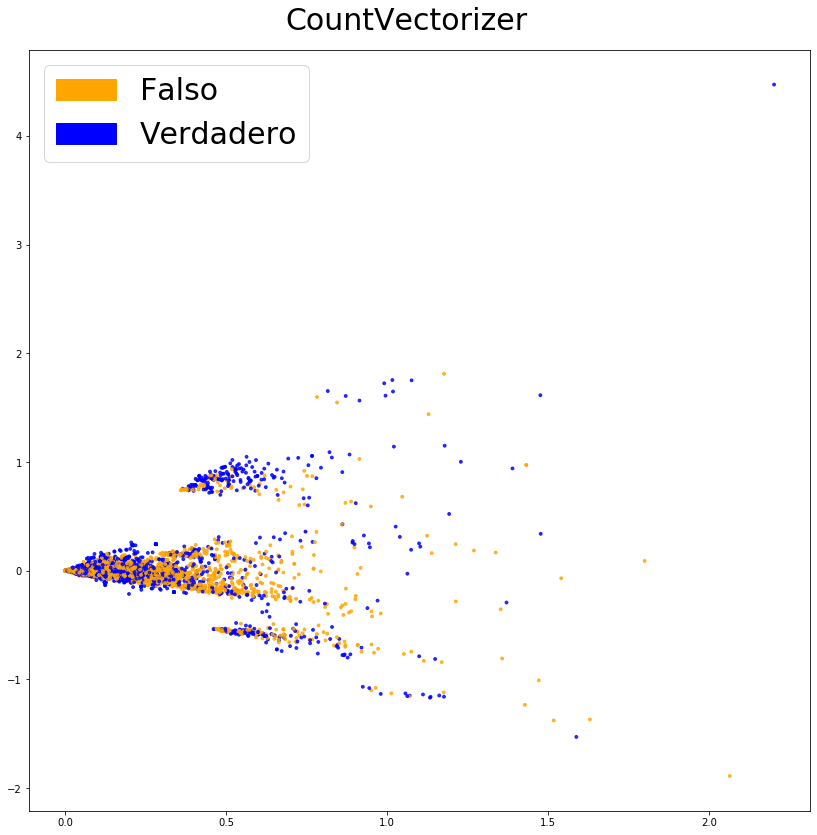

In [38]:
#Grafico vectorizacion
graph_cv =  count_vectorizer.fit_transform(X_train)
Graph_vectorization(graph_cv,y_train,"CountVectorizer")

### 3.3.2 TF-IDF
Tf-idf (Term frequency – Inverse document frequency), frecuencia de término – frecuencia inversa de documento (o sea, la frecuencia de ocurrencia del término en la colección de documentos), es una medida numérica que expresa cuán relevante es una palabra para un documento en una colección. 
Es una mejora de Bag of Words ya que contabiliza y pondera las palabras en base a su frecuencia de aparición en el documento, por ejemplo la palabra "the" puede tener muchas apariciones en el texto, por lo que se podria dar una importancia menor.

**Parámetros TfidfVectorizer**

* _mindf_ = cantidad o porcentaje minimo de aparición del token en todos los documentos. En este caso se descartan todas las que tengan menos de 2 apariciones

* _maxdf_ = cantidad o porcentaje maximo de aparición del token. En este caso se descartan todos los token que tengan una frecuencia de aparición mayor al 50%

* _ngramrange_ = Rango de ngramas a utilizar para generar los tokens. En este caso se usan desde 1 a 2 gramas (uni y bi-grama)


In [39]:
# Vectorizacion utilizando TF-IDF (UNI Y BI-GRAMAS)
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tf = tfidf.fit_transform(train_df2['text'])
test_tf = tfidf.transform(test_df2["text"])

* _Se toman los valores (min_df, max_df) porque acortan la dimensionalidad de los vectores_
* _Se utilizan uni y bi gramas porque mejora notablemente el scorde de clasificacion al agregar bi-gramas_


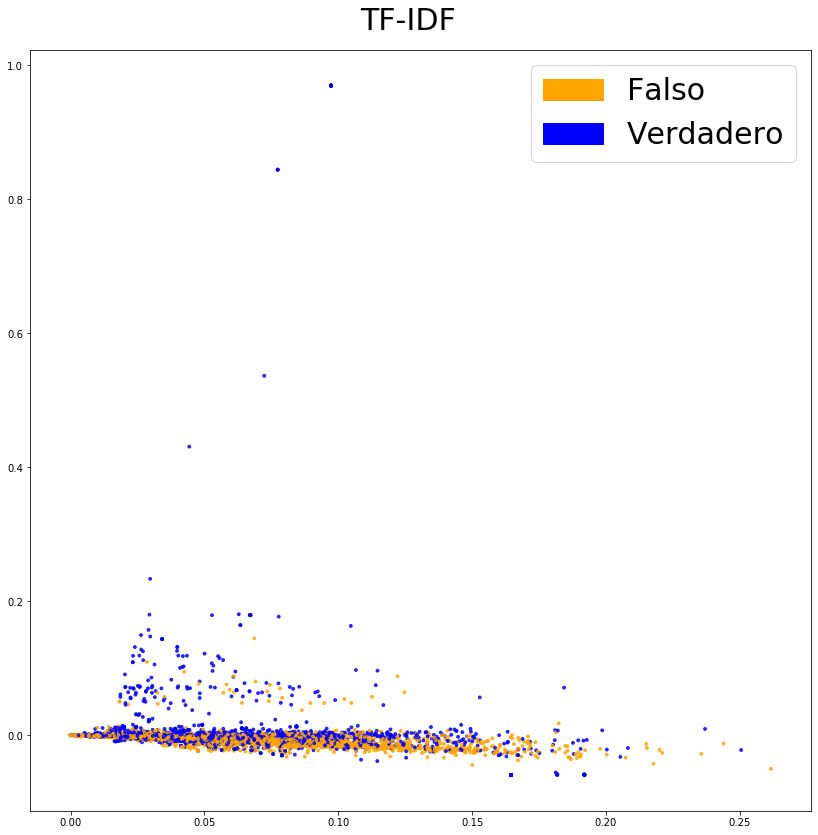

In [40]:
#Grafico vectorizacion
graph_tf =  tfidf.fit_transform(X_train)
Graph_vectorization(graph_tf,y_train,"TF-IDF")

### 3.3.4 N-Gramas
Agrupo las palabras en grupos de 1,2,3,n palabras, para agregarles un contexto.

Esto se puede lograr utilizando countVectorize para analizar la frecuencia de aparición de n-gramas o combinarlo con tf-idf para considerar la ponderación del término en base a sus apariciones.

In [41]:
# Agrupo por bi-gramas y tri-gramas con CountVectorizer
ngram_cv = CountVectorizer(ngram_range=(2,3))
train_ng_cv = ngram_cv.fit_transform(train_df2['text'])
test_ng_cv = ngram_cv.transform(test_df2["text"])

In [42]:
# Agrupo por bi-gramas y tri-gramas con TF-IDF
ngram_tf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(2, 3))
train_ng_tf = ngram_tf.fit_transform(train_df2['text'])
test_ng_tf = ngram_tf.transform(test_df2["text"])

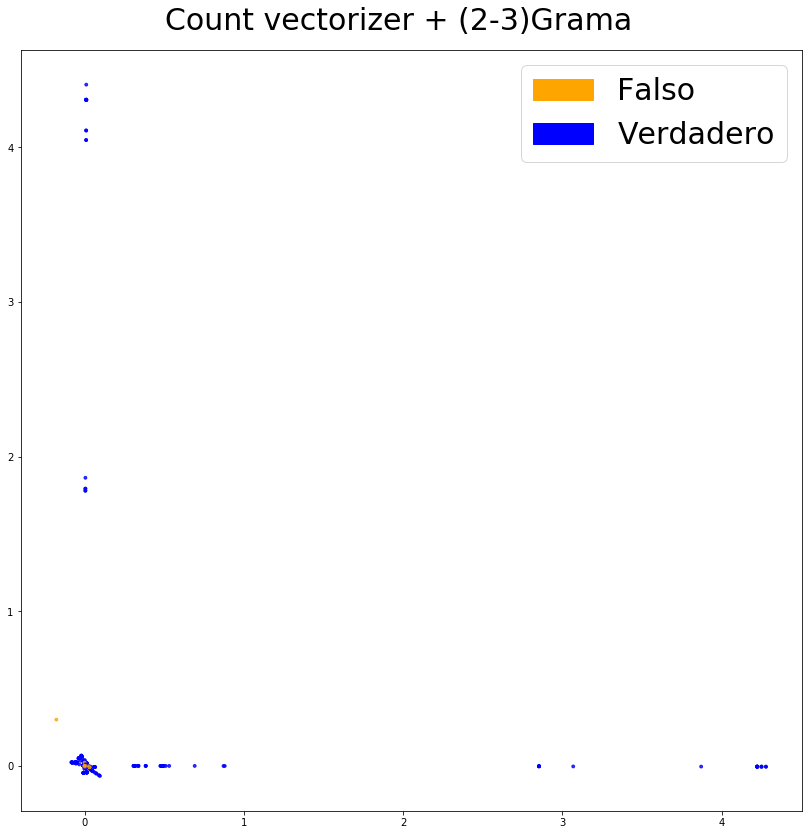

In [43]:
#Grafico vectorizacion
graph_cv_ngs =  ngram_cv.fit_transform(X_train)
Graph_vectorization(graph_cv_ngs,y_train,"Count vectorizer + (2-3)Grama")


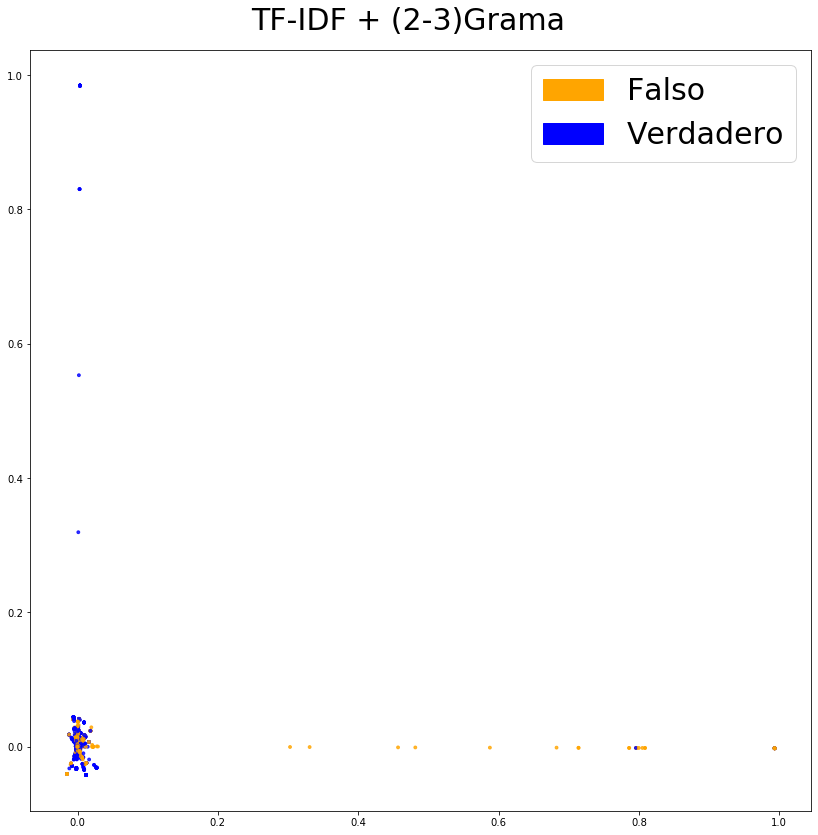

In [44]:
#Grafico vectorizacion
graph_tf_ng =  ngram_tf.fit_transform(X_train)
Graph_vectorization(graph_tf_ng,y_train,"TF-IDF + (2-3)Grama")

### 3.3.5 Feature Hashing


In [45]:
#Vectorizacion usando Feature hashing
hv = HashingVectorizer()
train_fh = hv.fit_transform(train_df2["text"])
test_fh = hv.transform(test_df2["text"])

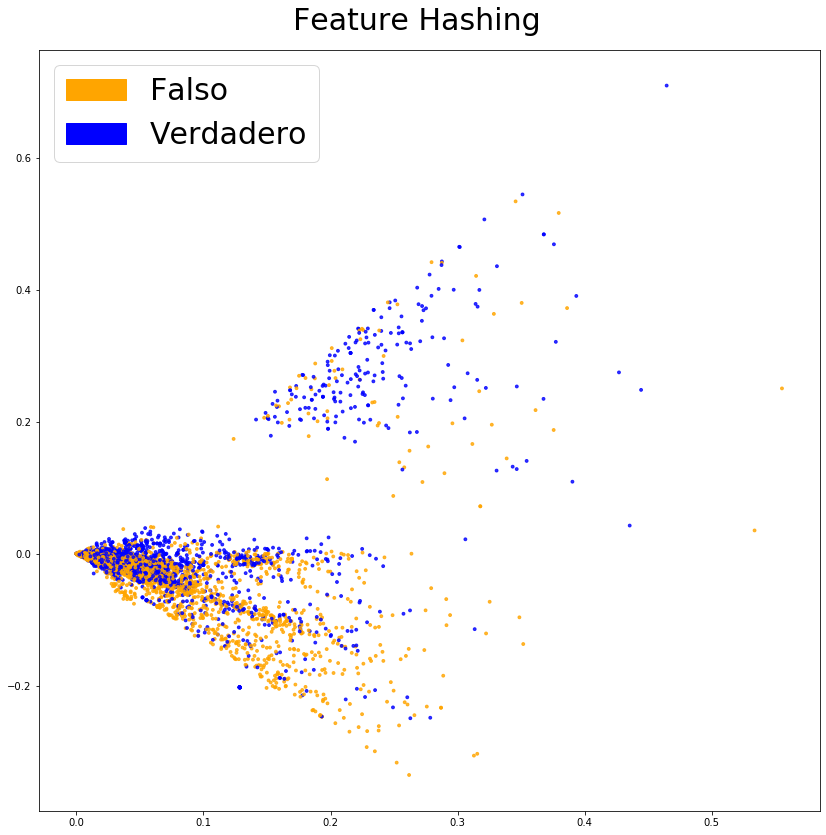

In [46]:
#Grafico vectorizacion
graph_fh =  hv.fit_transform(X_train)
Graph_vectorization(graph_fh,y_train,"Feature Hashing")

# 4. Comparación de modelos
Para tener un poco mas ordenado todo, agrupo los algortimos en una colección para luego poder evaluarlos en bloque.
La función para evaluarlos recibe los vectores y los evalua con todos los modelos en el diccionario. Para clasificarlos utiliza una parte para entrenamiento y otra para test, luego de ajustar al modelo compara el acierto con las metricas AUC (area bajo la curva), presicion train, precision test y F1

In [47]:
def graph_classifier(x_train, y_train,title,modelsDict):
    results = []
    names = []
    for key, classifier in modelsDict.items():
        kfold = model_selection.KFold(n_splits=10, random_state=2020)
        cv_results = model_selection.cross_val_score(classifier, x_train, y_train, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(key)    
        
    fig = plt.figure(figsize=(16,8))
    plt.title(title)
    fig.suptitle('Comparación de algoritmos')    
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)    
    plt.axhline(y=0.80, color='g', linestyle='-')
    plt.show()


In [48]:

def batch_classify(x_train, y_train, x_test, y_test,positive_values = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,6)), columns = ['Clasificador', 'Prec. train', 'Prec. test','AUC score','F1', 'Tiempo transcurrido'])
    count = 0
    for key, classifier in modelsDict.items():
        if positive_values == False and key == "MNB":
            continue
            
        t_start = process_time()  
        df_results.loc[count,'Clasificador'] = key        
        try:
            classifier.fit(x_train, y_train)
            t_stop = process_time() 
            t_elapsed = t_stop - t_start        
            y_predicted = classifier.predict(x_test)
            df_results.loc[count,'AUC score'] = roc_auc_score(y_test, y_predicted)
            df_results.loc[count,'Prec. train'] = round(classifier.score(x_train, y_train)*100)
            df_results.loc[count,'Prec. test'] =round(accuracy_score(y_test,y_predicted)*100) 
            df_results.loc[count,'F1'] = f1_score(y_test, y_predicted, zero_division=1)
            df_results.loc[count,'Tiempo transcurrido'] = t_elapsed 
        except Exception as e:
            #agrego esto para los casos de vectores negativos para seguir adelante y no analizar ese modelo
            print(e)
        
                       
        count+=1

    return df_results


# 4.1 Resultados
Comparo la performance de los distintos modelos probados

In [82]:
modelsDict = {    
    "Gradient Boost": GradientBoostingClassifier(n_estimators=1),
    "Random Forest": RandomForestClassifier(max_depth = 10),  
    "Decision Tree": DecisionTreeClassifier(max_depth = 10),
    "kNN": KNeighborsClassifier(),
    'MNB': MultinomialNB(),
    'GNB': GaussianNB(),
    'RidgeClassifier': RidgeClassifier(class_weight='balanced'),
    'Perceptron': Perceptron(class_weight='balanced'),
    'xgboost': XGBClassifier(n_estimators=10),
    "Logistic Regression": LogisticRegression(C=1.0)
    }

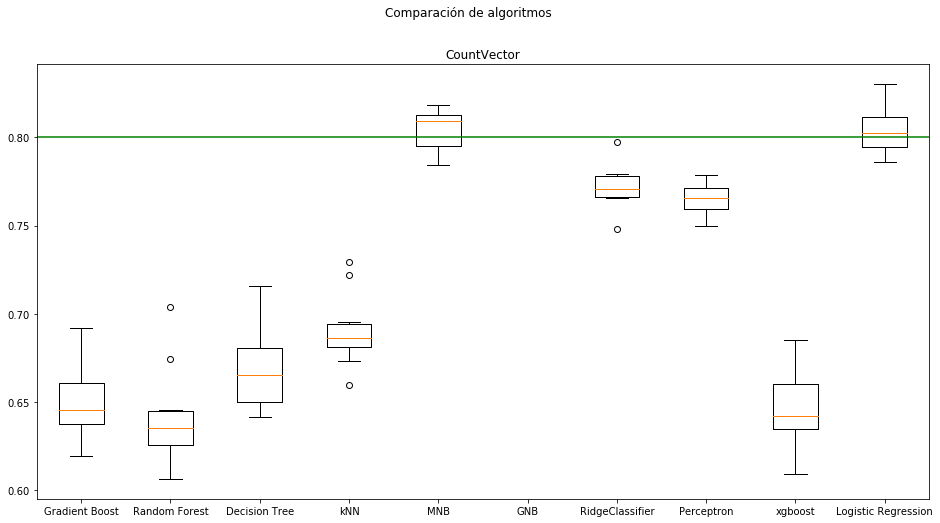

In [50]:
#Datos para countVector
x_train_cv, x_test_cv, y_train_cv, y_test_cv =train_test_split(train_cv,tweets_train.target,test_size=0.2,random_state=2020)
graph_classifier(x_train_cv, y_train_cv,"CountVector",modelsDict)

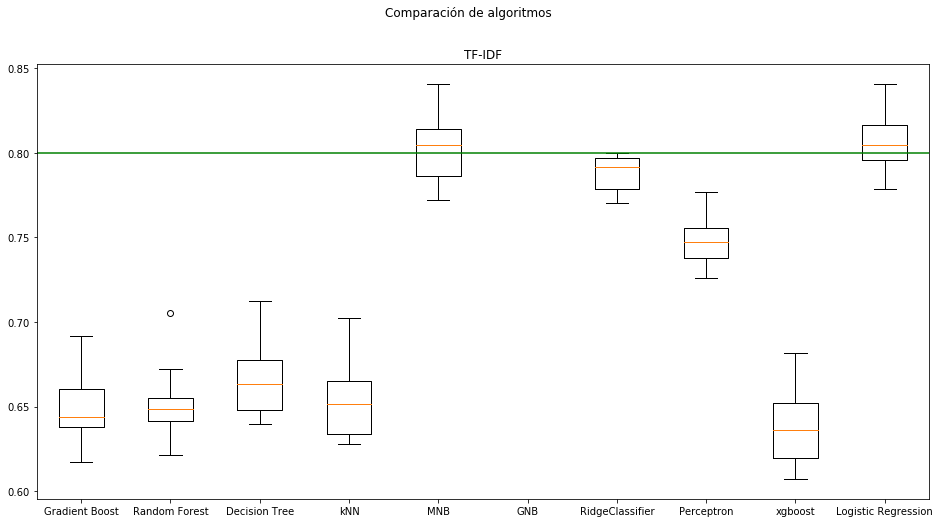

In [51]:
#Datos para TF-IDF
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(train_tf,tweets_train.target,test_size=0.2,random_state=2020)
graph_classifier(x_train_tf, y_train_tf,"TF-IDF",modelsDict)

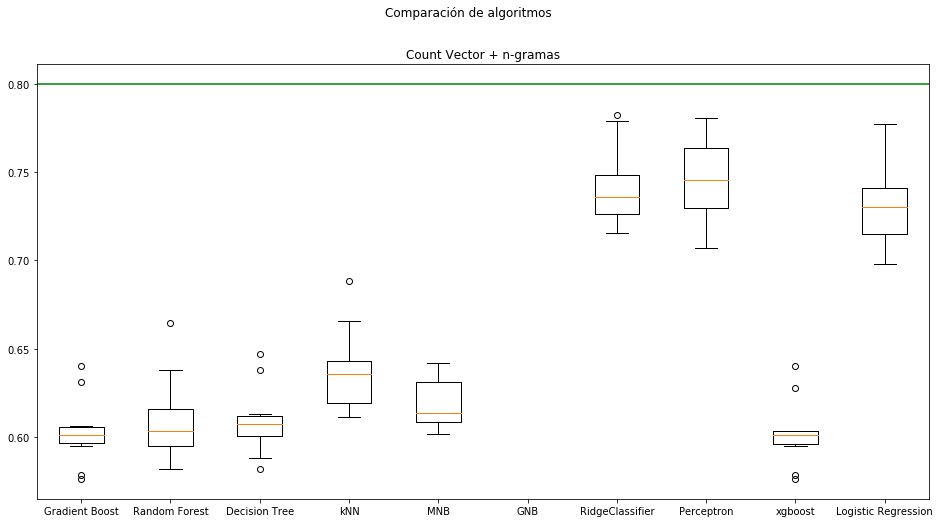

In [52]:
#Datos para countVector + n-gramas
x_train_ng_cv, x_test_ng_cv, y_train_ng_cv, y_test_ng_cv =train_test_split(train_ng_cv,tweets_train.target,test_size=0.2,random_state=2020)
graph_classifier(x_train_ng_cv, y_train_ng_cv,"Count Vector + n-gramas",modelsDict)

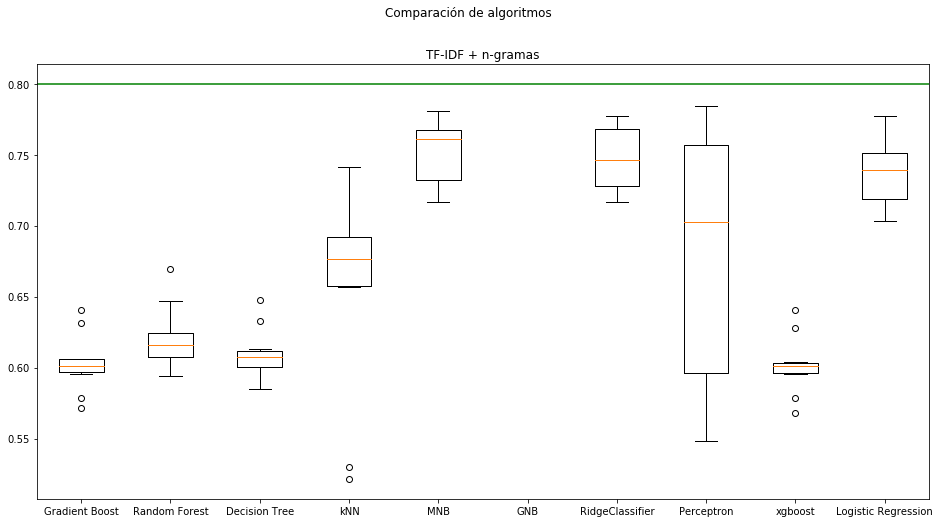

In [53]:
#Datos para TF-IDF + n-gramas
x_train_ng_tf, x_test_ng_tf, y_train_ng_tf, y_test_ng_tf = train_test_split(train_ng_tf,tweets_train.target,test_size=0.2,random_state=2020)
graph_classifier(x_train_ng_tf, y_train_ng_tf,"TF-IDF + n-gramas",modelsDict)

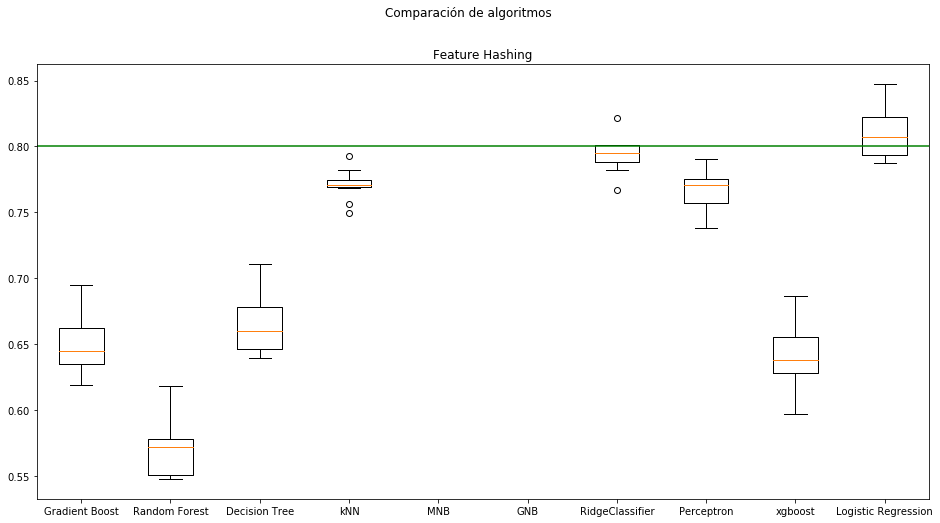

In [54]:
#Datos para Feature hashing
x_train_fh, x_test_fh, y_train_fh, y_test_fh = train_test_split(train_fh,tweets_train.target,test_size=0.2,random_state=2020)
graph_classifier(x_train_fh, y_train_fh,"Feature Hashing",modelsDict)

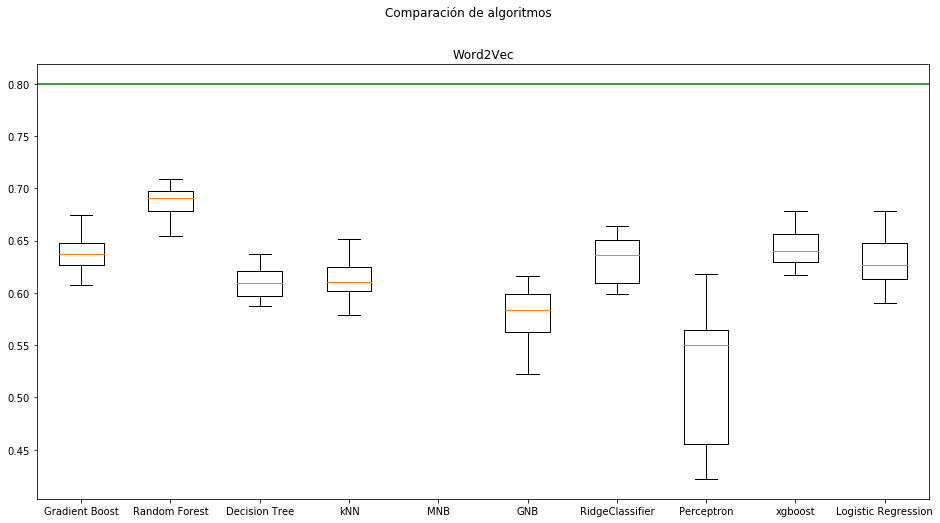

In [55]:
#Datos para w2vec
x_train_w2vec, x_test_w2vec, y_train_w2vec, y_test_w2vec = train_test_split(train_w2vec,tweets_train.target,test_size=0.2,random_state=2020)
graph_classifier(x_train_w2vec, y_train_w2vec,"Word2Vec",modelsDict)

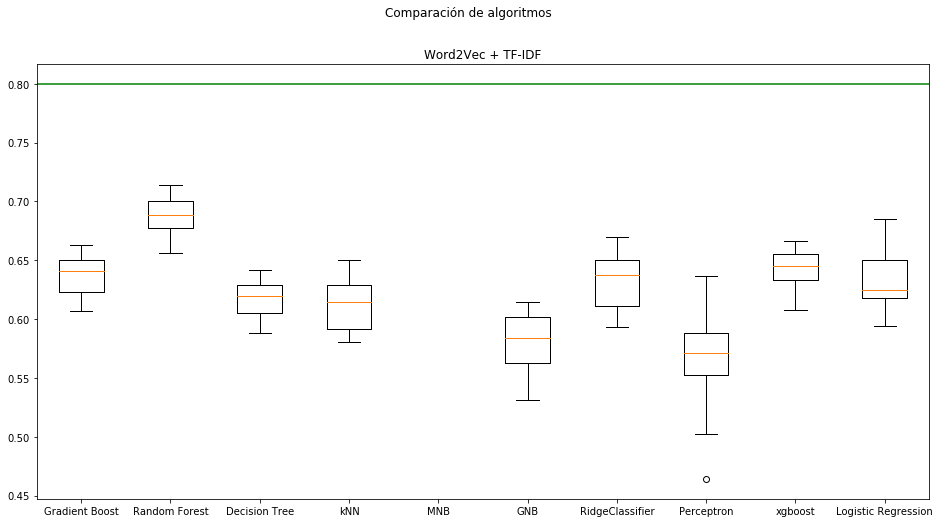

In [56]:
#Datos para w2vec + tfidf
x_train_w2vecTfid, x_test_w2vecTfid, y_train_w2vecTfid, y_test_w2vecTfid = train_test_split(train_w2vecTfid,tweets_train.target,test_size=0.2,random_state=2020)
graph_classifier(x_train_w2vecTfid, y_train_w2vecTfid,"Word2Vec + TF-IDF",modelsDict)

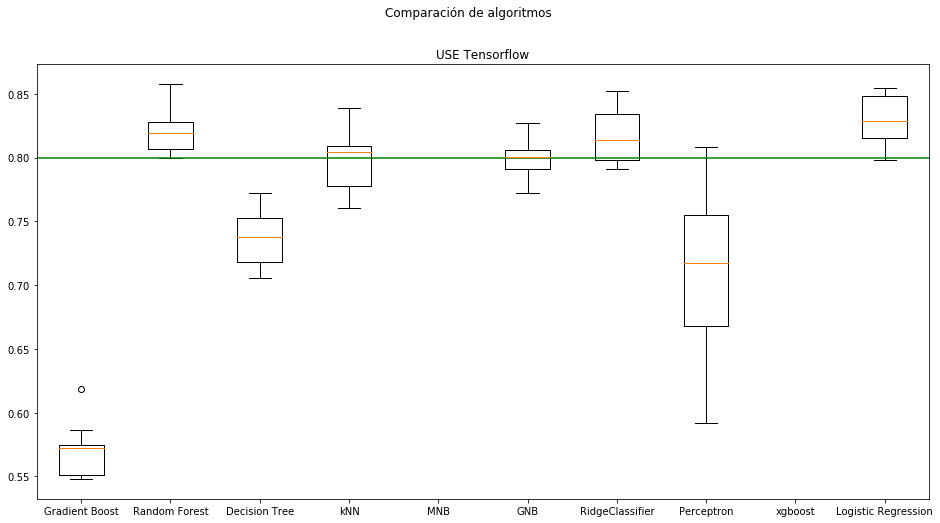

In [83]:
#Datos para U.S.E TF
x_train_usetf, x_test_usetf, y_train_usetf, y_test_usetf = train_test_split(train_use_tf,tweets_train.target,test_size=0.2,random_state=2020)
graph_classifier(x_train_usetf, y_train_usetf,"USE Tensorflow",modelsDict)

# 5. Mejora de modelos

## 5.0 Preparacion de datasets
Preparo datasets especiales para entrenamiento de los modelos

### 5.0.1 Universal sentence encoder 
Preparo dataframes con la vectorizacón para:
1. Solo la columna texto
2. Columna texto y columna Keyword
3. Texto + Keyword y score de sentiment analisys

In [58]:
##Convierto la lista a dataframe, le agrego las columnas de KEYWORD
train_use_tf2 = pd.DataFrame(train_use_tf)
train_use_k_tf2 = pd.DataFrame(train_use_tf_k)
train_use_tf2_k = pd.concat([train_use_tf2, train_use_k_tf2], axis=1, sort=False)

#Mismo pero con sentimient analysis
train_use_tf2_s = pd.concat([train_use_tf2_k.reset_index(drop=True), train_df2['sentiment_score'].reset_index(drop=True)], axis=1, sort=False)


#---test----
##Convierto la lista a dataframe, le agrego las columnas de KEYWORD
test_use_tf2 = pd.DataFrame(test_use_tf)
test_use_k_tf2 = pd.DataFrame(test_use_tf_k)
test_use_tf2_k = pd.concat([test_use_tf2, test_use_k_tf2], axis=1, sort=False)

#Mismo pero con sentimient analysis
test_use_tf2_s = pd.concat([test_use_tf2_k, test_df2['sentiment_score']], axis=1, sort=False)

## 5.1 Búsqueda de hiper-parámetros
Busco los mejores hiperparámetros para los distintos modelos probando diferentes vectorizaciones siempre que sea posible (por ejemplo, algunos modelos no soportan valores negativos en el vector)

Función para hacer validacion cruzada. Recibe dos parametros: El modelo a analizar (classifier) y los parámetros a probar.

### 5.1.1 Preparación de diccionarios/funciones
Preparo un diccionario con cada una de las vectorizaciones que utilizará la función de evaluación del modelo

In [ ]:
#Diccionario con las vectorizaciones obtenidas previamente
vectorDict = {    
    "Count Vector": train_cv,
    "TF-IDF": train_tf,
    "Count Vector + ng": train_ng_cv,
    "TF-IDF + ng": train_ng_tf,
    "Feature Hashing": train_fh,
    "Word2Vec": train_w2vec,
    "Word2Vec + TF-IDF": train_w2vecTfid,
    "Universal sentence encoder": train_use_tf2,
    "Universal full":train_use_tf2_k,
    "USE Sentiment" : train_use_tf2_s
    }

Función que utiliza gridSearch para hacer cross-validation sobre los modelos con los distintos hiperparámetros e imprime el score, mejores parametro y mejor modelo

In [ ]:
def Cross_validation(classifier,paramDict):
    for key,param_grid in paramDict.items():
        try:
            grid_search = GridSearchCV(estimator= classifier[key], param_grid = param_grid, cv=3 , n_jobs = -1, verbose = 2)
            grid_search.fit(vectorDict[key],tweets_train.target)
            print(key)
            print(grid_search.best_score_)
            print(grid_search.best_params_)
            print(grid_search.best_estimator_)
        except Exception as e:
            #agrego esto para los casos de vectores negativos para seguir adelante y no analizar ese modelo
            print(e)



## 5.2 Gradient Boost

Gradient boost es un algoritmo que se encuentra dentro de la categoría de los clasificadores de **boosting**.
Boosting es una técnica secuencial que se basa en el principio de ensemble. Consiste en combinar un set de clasificadores debíles de manera consecutiva, donde para cada predicción se toman los valores obtenidos y se van arrastrando a las siguientes ejecuciones. 

### 5.2.1 Hiperparámetros

Existen dos tipos de hiperparámetros, los basados en la estructura de arbol y los parámetros de "boosting". 
No existen valores óptimos para el ratio de aprendizaje (learing rate), valores mas bajos dan mejores resultados a coste de un mayor tiempo de procesamiento y un gran número de árboles pueden llevar a dar overfitting.

Teniendo en cuenta lo anterior se toma:
* Inicialmente se tomarán valores altos para el learning rate (1, 0.1), esto nos permite trabajar con una mayor cantidad de árboles con una buena performance.
* Una cantidad baja de estimators reduce la precisión pero baja la cantidad de recursos consumidos.
* Probamos con un valor alto de árboles tratando de no dar overfitting
* Se probarán los parametrós específicos de arbol (Estructura)
* Se probarán los parametros de boosting (Mejora de modelo)
* Con los parametrós determinados se bajará el learning rate y se incrementarán los estimators para obtener modelos mas robustos.

Para probar los parámetros se debe empezar por los de mayor impacto. el orden será el siguiente:
1. max_depth - min_samples_split
2. min_samples_leaf - min-samples-split
3. max_features



In [215]:
#Modelo Inicial
modelGB = {
    "Word2Vec": GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, subsample=0.8, random_state=2020),
    "Word2Vec + TF-IDF":GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, subsample=0.8, random_state=2020) ,
    "Universal sentence encoder":GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, subsample=0.8, random_state=2020),
    "Universal full":GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, subsample=0.8, random_state=2020),
    "USE Sentiment":GradientBoostingClassifier(learning_rate=0.005, n_estimators=1400, subsample=0.8, random_state=2020)
}

### 5.2.2 Paso 1: max_depth - min_samples_split 

In [216]:
step_1 ={
    "Word2Vec":{'max_depth':range(2,4,1), 'min_samples_split':range(150,250,50)},
    "Word2Vec + TF-IDF":{'max_depth':range(2,4,1), 'min_samples_split':range(150,250,50)},
    "Universal sentence encoder":{'max_depth':range(2,4,1), 'min_samples_split':range(100,301,50)},
    "Universal full":{'max_depth':range(2,4,1), 'min_samples_split':range(50,201,50)},
    "USE Sentiment":{'max_depth':range(2,4,1), 'min_samples_split':range(0,101,50)}
}
Cross_validation(modelGB,step_1)

'Word2Vec'
'Word2Vec + TF-IDF'
'Universal sentence encoder'
'Universal full'
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed: 17.4min remaining: 11.1min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 35.4min finished


USE Sentiment
0.7835546161784551
{'max_depth': 2, 'min_samples_split': 100}
GradientBoostingClassifier(learning_rate=0.005, max_depth=2,
                           min_samples_split=100, n_estimators=1400,
                           random_state=2020, subsample=0.8)


In [217]:
#Ajuste Paso 1
step_1_deep ={
    "Word2Vec":{'max_depth':[3], 'min_samples_split':[195,200,205]},
    "Word2Vec + TF-IDF":{'max_depth':[3], 'min_samples_split':[170,180,190]},
    "Universal sentence encoder":{'max_depth':[3], 'min_samples_split':[190,200,210]},
    "Universal full":{'max_depth':[3], 'min_samples_split':[95,100,105]},
    "USE Sentiment":{'max_depth':[2], 'min_samples_split':[90,100,110]}
}
Cross_validation(modelGB,step_1_deep)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 18.0min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 26.0min finished


USE Sentiment
0.7835546161784551
{'max_depth': 2, 'min_samples_split': 100}
GradientBoostingClassifier(learning_rate=0.005, max_depth=2,
                           min_samples_split=100, n_estimators=1400,
                           random_state=2020, subsample=0.8)


### 5.2.3 Paso 2: min_samples_leaf - min-samples-split 

In [219]:
#Modelo
modelGB = {
    "Word2Vec":GradientBoostingClassifier(min_samples_split=200, n_estimators=60,
                          random_state=2020, subsample=0.8),
    "Word2Vec + TF-IDF":GradientBoostingClassifier(min_samples_split=180, n_estimators=60,
                          random_state=2020, subsample=0.8),
    "Universal sentence encoder":GradientBoostingClassifier(min_samples_split=200, n_estimators=60,
                           random_state=2020, subsample=0.8),
    "Universal full":GradientBoostingClassifier(min_samples_split=100, n_estimators=60,
                           random_state=2020, subsample=0.8),
    "USE Sentiment":GradientBoostingClassifier(learning_rate=0.005, max_depth=2,
                           min_samples_split=100, n_estimators=1400,
                           random_state=2020, subsample=0.8)
}

In [222]:
step_2 ={
    "Word2Vec":{'min_samples_split':range(150,170,10), 'min_samples_leaf':range(10,25,5)},
    "Word2Vec + TF-IDF":{'min_samples_split':range(0,21,5), 'min_samples_leaf':(50,70,5)},
    "Universal sentence encoder":{'min_samples_split':range(0,101,10), 'min_samples_leaf':range(40,44,1)},
    "Universal full":{'min_samples_split':range(0,101,10), 'min_samples_leaf':range(20,100,10)},
    "USE Sentiment":{'min_samples_split':range(1,10,1), 'min_samples_leaf':range(30,51,10)}
}
Cross_validation(modelGB,step_2)

'Word2Vec'
'Word2Vec + TF-IDF'
'Universal sentence encoder'
'Universal full'
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 60.8min finished


USE Sentiment
0.7823208380242049
{'min_samples_leaf': 30, 'min_samples_split': 2}
GradientBoostingClassifier(learning_rate=0.005, max_depth=2,
                           min_samples_leaf=30, n_estimators=1400,
                           random_state=2020, subsample=0.8)


In [224]:
#Ajuste paso 2
step_2_deep ={
    "Word2Vec":{'min_samples_split':[153,155,157], 'min_samples_leaf':[19,20,21]},
    "Word2Vec + TF-IDF":{'min_samples_split':[16,17,18], 'min_samples_leaf':[6,7,8]},
    "Universal sentence encoder":{'min_samples_split':[80,90,100], 'min_samples_leaf':[41,42,43]},
    "Universal full":{'min_samples_split':[63,65,67], 'min_samples_leaf':[20,22,24,26,28,30]},
    "USE Sentiment":{'min_samples_split':[2], 'min_samples_leaf':[10,20,30]}
}
Cross_validation(modelGB,step_2_deep)

'Word2Vec'
'Word2Vec + TF-IDF'
'Universal sentence encoder'
'Universal full'
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 17.4min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 25.6min finished


USE Sentiment
0.7831434319679289
{'min_samples_leaf': 20, 'min_samples_split': 2}
GradientBoostingClassifier(learning_rate=0.005, max_depth=2,
                           min_samples_leaf=20, n_estimators=1400,
                           random_state=2020, subsample=0.8)


### 5.2.4 Paso 3: max_features

In [226]:
#Modelo
modelGB = {
    "Word2Vec":GradientBoostingClassifier(min_samples_leaf=20, min_samples_split=153,
                           n_estimators=60, random_state=2020, subsample=0.8)
    "Word2Vec + TF-IDF":GradientBoostingClassifier(min_samples_leaf=8, min_samples_split=16,
                           n_estimators=60, random_state=2020, subsample=0.8),
    "Universal sentence encoder":GradientBoostingClassifier(min_samples_leaf=42, min_samples_split=100,
                           n_estimators=60, random_state=2020, subsample=0.8),
    "Universal full":GradientBoostingClassifier(min_samples_leaf=20, min_samples_split=65,
                           n_estimators=60, random_state=2020, subsample=0.8),
    "USE Sentiment":GradientBoostingClassifier(learning_rate=0.005, max_depth=2,
                           min_samples_leaf=20, n_estimators=1400,
                           random_state=2020, subsample=0.8)
}

In [227]:
step_3 ={
    "Word2Vec":{'max_features':range(60,120,1)},
    "Word2Vec + TF-IDF":{'max_features':range(60,120,1)},
    "Universal sentence encoder":{'max_features':range(60,120,1)},
    "Universal full":{'max_features':range(60,120,1)},
    "USE Sentiment":{'max_features':range(10,120,20)}
}
Cross_validation(modelGB,step_3)

'Word2Vec'
'Word2Vec + TF-IDF'
'Universal sentence encoder'
'Universal full'
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.9min finished


USE Sentiment
0.7887635696991347
{'max_features': 110}
GradientBoostingClassifier(learning_rate=0.005, max_depth=2, max_features=110,
                           min_samples_leaf=20, n_estimators=1400,
                           random_state=2020, subsample=0.8)


### 5.2.5 Paso 4: Subsampleo

In [230]:
#Modelo
modelGB = {
    "Word2Vec":GradientBoostingClassifier(min_samples_leaf=20, min_samples_split=153,
                           n_estimators=60, random_state=2020, subsample=0.8,max_features = 80),
    "Word2Vec + TF-IDF":GradientBoostingClassifier(min_samples_leaf=8, min_samples_split=16,
                           n_estimators=60, random_state=2020, subsample=0.8,max_features = 112),
    "Universal sentence encoder":GradientBoostingClassifier(min_samples_leaf=42, min_samples_split=100,
                          n_estimators=60, random_state=2020, subsample=0.8,max_features = 72),
    "Universal full":GradientBoostingClassifier(min_samples_leaf=20, min_samples_split=65,
                           n_estimators=60, random_state=2020, subsample=0.8,max_features = 72),
    "USE Sentiment":GradientBoostingClassifier(learning_rate=0.005, max_depth=2, max_features=110,
                           min_samples_leaf=20, n_estimators=1400,
                           random_state=2020, subsample=0.86)
}

In [232]:
step_4 = {
    "Word2Vec":{'subsample':[0.75,0.77,0.8,0.83,0.85]},
    "Word2Vec + TF-IDF":{'subsample':[0.75,0.77,0.8,0.83,0.85]},
    "Universal sentence encoder":{'subsample':[0.75,0.77,0.8,0.83,0.85]},
    "Universal full":{'subsample':[0.75,0.77,0.8,0.83,0.85]},
    "USE Sentiment":{'subsample':[0.81,0.82,0.83,0.84,0.86,0.88,0.9]}
}
Cross_validation(modelGB,step_4)



'Word2Vec'
'Word2Vec + TF-IDF'
'Universal sentence encoder'
'Universal full'
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  6.1min finished


USE Sentiment
0.7898598354045335
{'subsample': 0.86}
GradientBoostingClassifier(learning_rate=0.005, max_depth=2, max_features=110,
                           min_samples_leaf=20, n_estimators=1400,
                           random_state=2020, subsample=0.86)


### 5.2.6 Ajuste final n_estimators, learning rate

In [233]:
#Modelo
modelGB = {
    "Word2Vec":GradientBoostingClassifier(min_samples_leaf=20, min_samples_split=153,
                            random_state=2020, subsample=0.8,max_features = 80),
    "Word2Vec + TF-IDF":GradientBoostingClassifier(min_samples_leaf=8, min_samples_split=16,
                            random_state=2020, subsample=0.8,max_features = 112),
    "Universal sentence encoder":GradientBoostingClassifier(min_samples_leaf=42, min_samples_split=100,
                            random_state=2020, subsample=0.75,max_features = 72),
    "Universal full":GradientBoostingClassifier(min_samples_leaf=20, min_samples_split=65,
                            random_state=2020, subsample=0.75,max_features = 72),
    "USE Sentiment":GradientBoostingClassifier(learning_rate=0.005, max_depth=2, max_features=110,
                           min_samples_leaf=20, n_estimators=1400,
                           random_state=2020, subsample=0.86)
}

In [234]:
step_5 = {
    "Word2Vec":{'learning_rate':[0.001,0.01],'n_estimators':[100,1000,2000]},
    "Word2Vec + TF-IDF":{'learning_rate':[0.001,0.01],'n_estimators':[100,1000,2000]},
    "Universal sentence encoder":{'learning_rate':[0.001,0.01],'n_estimators':[100,1000,2000]},
    "Universal full":{'learning_rate':[0.001,0.01],'n_estimators':[100,1000,2000]},
    "USE Sentiment":{'learning_rate':[0.001,0.002,0.003,0.004,0.005,0.006],'n_estimators':[1350,1400,1450]},
}
Cross_validation(modelGB,step_5)


'Word2Vec'
'Word2Vec + TF-IDF'
'Universal sentence encoder'
'Universal full'
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 14.4min finished


USE Sentiment
0.7898598354045335
{'learning_rate': 0.005, 'n_estimators': 1400}
GradientBoostingClassifier(learning_rate=0.005, max_depth=2, max_features=110,
                           min_samples_leaf=20, n_estimators=1400,
                           random_state=2020, subsample=0.86)


### 5.2.7 Modelo Final

In [60]:
modelGB = {
    "Count Vector": GradientBoostingClassifier(),
    "TF-IDF": GradientBoostingClassifier(),
    "Count Vector + ng":GradientBoostingClassifier(),
    "TF-IDF + ng": GradientBoostingClassifier(),
    "Feature Hashing":GradientBoostingClassifier(),
    "Word2Vec": GradientBoostingClassifier(min_samples_leaf=20, min_samples_split=153,
                            random_state=2020, subsample=0.8,max_features = 80),
    "Word2Vec + TF-IDF":GradientBoostingClassifier(min_samples_leaf=8, min_samples_split=16,
                            random_state=2020, subsample=0.8,max_features = 112) ,
    "Universal sentence encoder":GradientBoostingClassifier(min_samples_leaf=42, min_samples_split=100,
                            random_state=2020, subsample=0.75,max_features = 72),
    "Universal full":GradientBoostingClassifier(min_samples_leaf=20, min_samples_split=65,
                            random_state=2020, subsample=0.75,max_features = 72),
    "USE Sentiment":GradientBoostingClassifier(learning_rate=0.0055, max_depth=2, max_features=27,
                           min_samples_leaf=23, n_estimators=4850,
                           random_state=2020, subsample=0.86)
}

## 5.3 Random Forest

La idea esencial del bagging es promediar muchos modelos ruidosos pero aproximadamente imparciales, y por tanto reducir la variación. Los árboles son los candidatos ideales para el bagging, dado que ellos pueden registrar estructuras de interacción compleja en los datos, y si crecen suficientemente profundo, tienen relativamente baja parcialidad. Producto de que los árboles son notoriamente ruidosos, ellos se benefician enormemente al promediar.

Cada árbol es construido usando el siguiente algoritmo:

1.   Sea N el número de casos de prueba, M es el número de variables en el clasificador.
2.    Sea m el número de variables de entrada a ser usado para determinar la decisión en un nodo dado; m debe ser mucho menor que M
3.   Elegir un conjunto de entrenamiento para este árbol y usar el resto de los casos de prueba para estimar el error.
4.   Para cada nodo del árbol, elegir aleatoriamente m variables en las cuales basar la decisión. Calcular la mejor partición del conjunto de entrenamiento a partir de las m variables.

Para la predicción un nuevo caso es empujado hacia abajo por el árbol. Luego se le asigna la etiqueta del nodo terminal donde termina. Este proceso es iterado por todos los árboles en el ensamblado, y la etiqueta que obtenga la mayor cantidad de incidencias es reportada como la predicción. 

In [287]:
modelRF = {
    #"Count Vector": RandomForestClassifier(max_depth = 10),
    #"TF-IDF": RandomForestClassifier(max_depth = 10),
    #"Count Vector + ng":RandomForestClassifier(max_depth = 10),
    #"TF-IDF + ng": RandomForestClassifier(max_depth = 10),
    #"Feature Hashing":RandomForestClassifier(max_depth = 10),
    #"Word2Vec": RandomForestClassifier(max_depth = 10),
    #"Word2Vec + TF-IDF": RandomForestClassifier(max_depth = 10),
    "Universal sentence encoder": RandomForestClassifier(max_depth = 10),
    "Universal full":RandomForestClassifier(max_depth = 10),
    "USE Sentiment" : RandomForestClassifier(max_depth = 10)
}

### 5.3.1 PASO 1: max-depth  -  min_samples_split

In [289]:
step_1 ={
    "Universal sentence encoder":{'max_depth':range(1,5,1), 'min_samples_split':range(0,200,50)},
    "Universal full":{'max_depth':range(1,5,1), 'min_samples_split':range(200,500,50)},
    "USE Sentiment":{'max_depth':range(1,5,1), 'min_samples_split':range(200,500,50)}
}
Cross_validation(modelRF,step_1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   19.4s finished


Universal sentence encoder
0.782182423484668
{'max_depth': 4, 'min_samples_split': 50}
RandomForestClassifier(max_depth=4, min_samples_split=50)
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   31.7s finished


Universal full
0.7213251306227312
{'max_depth': 4, 'min_samples_split': 400}
RandomForestClassifier(max_depth=4, min_samples_split=400)
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   28.7s finished


USE Sentiment
0.7231074362943558
{'max_depth': 4, 'min_samples_split': 300}
RandomForestClassifier(max_depth=4, min_samples_split=300)


### 5.3.2 Paso2: min_samples_split - min_samples_leaf

In [293]:
modelRF = {
    #"Count Vector": RandomForestClassifier(max_depth = 10),
    #"TF-IDF": RandomForestClassifier(max_depth = 10),
    #"Count Vector + ng":RandomForestClassifier(max_depth = 10),
    #"TF-IDF + ng": RandomForestClassifier(max_depth = 10),
    #"Feature Hashing":RandomForestClassifier(max_depth = 10),
    #"Word2Vec": RandomForestClassifier(max_depth = 10),
    #"Word2Vec + TF-IDF": RandomForestClassifier(max_depth = 10),
    "Universal sentence encoder": RandomForestClassifier(max_depth=4, min_samples_split=50),
    "Universal full": RandomForestClassifier(max_depth=4, min_samples_split=400),
    "USE Sentiment" : RandomForestClassifier(max_depth=4, min_samples_split=300)
}

In [294]:
step_2 ={
    "Universal sentence encoder":{'min_samples_split':range(0,101,10), 'min_samples_leaf':range(40,44,1)},
    "Universal full":{'min_samples_split':range(0,101,10), 'min_samples_leaf':range(20,100,10)},
    "USE Sentiment":{'min_samples_split':range(1,10,1), 'min_samples_leaf':range(30,51,10)}
}
Cross_validation(modelRF,step_2)

Fitting 3 folds for each of 44 candidates, totalling 132 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:  1.2min finished


Universal sentence encoder
0.7825934385531909
{'min_samples_leaf': 41, 'min_samples_split': 80}
RandomForestClassifier(max_depth=4, min_samples_leaf=41, min_samples_split=80)
Fitting 3 folds for each of 88 candidates, totalling 264 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:  2.2min finished


Universal full
0.730921233049716
{'min_samples_leaf': 40, 'min_samples_split': 70}
RandomForestClassifier(max_depth=4, min_samples_leaf=40, min_samples_split=70)
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   41.2s finished


USE Sentiment
0.7317434887094331
{'min_samples_leaf': 50, 'min_samples_split': 7}
RandomForestClassifier(max_depth=4, min_samples_leaf=50, min_samples_split=7)


### 5.3.3 Max_features

In [295]:
modelRF = {
    #"Count Vector": RandomForestClassifier(max_depth = 10),
    #"TF-IDF": RandomForestClassifier(max_depth = 10),
    #"Count Vector + ng":RandomForestClassifier(max_depth = 10),
    #"TF-IDF + ng": RandomForestClassifier(max_depth = 10),
    #"Feature Hashing":RandomForestClassifier(max_depth = 10),
    #"Word2Vec": RandomForestClassifier(max_depth = 10),
    #"Word2Vec + TF-IDF": RandomForestClassifier(max_depth = 10),
    "Universal sentence encoder": RandomForestClassifier(max_depth=4, min_samples_leaf=41, min_samples_split=80),
    "Universal full": RandomForestClassifier(max_depth=4, min_samples_leaf=40, min_samples_split=70),
    "USE Sentiment" : RandomForestClassifier(max_depth=4, min_samples_leaf=50, min_samples_split=7)
}

In [296]:
step_3 ={
    "Word2Vec":{'max_features':range(60,120,1)},
    "Word2Vec + TF-IDF":{'max_features':range(60,120,1)},
    "Universal sentence encoder":{'max_features':range(60,120,1)},
    "Universal full":{'max_features':range(60,120,1)},
    "USE Sentiment":{'max_features':range(10,120,20)}
}
Cross_validation(modelRF,step_3)

'Word2Vec'
'Word2Vec + TF-IDF'
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  6.5min finished


Universal sentence encoder
0.7814966090411136
{'max_features': 72}
RandomForestClassifier(max_depth=4, max_features=72, min_samples_leaf=41,
                       min_samples_split=80)
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.4min finished


Universal full
0.7594298922182049
{'max_features': 113}
RandomForestClassifier(max_depth=4, max_features=113, min_samples_leaf=40,
                       min_samples_split=70)
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   20.5s finished


USE Sentiment
0.7555927367266376
{'max_features': 110}
RandomForestClassifier(max_depth=4, max_features=110, min_samples_leaf=50,
                       min_samples_split=7)


### 5.3.4 Paso 4: Ajuste n_estimators

In [299]:
modelRF = {
    #"Count Vector": RandomForestClassifier(max_depth = 10),
    #"TF-IDF": RandomForestClassifier(max_depth = 10),
    #"Count Vector + ng":RandomForestClassifier(max_depth = 10),
    #"TF-IDF + ng": RandomForestClassifier(max_depth = 10),
    #"Feature Hashing":RandomForestClassifier(max_depth = 10),
    #"Word2Vec": RandomForestClassifier(max_depth = 10),
    #"Word2Vec + TF-IDF": RandomForestClassifier(max_depth = 10),
    "Universal sentence encoder": RandomForestClassifier(max_depth=4, max_features=72, min_samples_leaf=41,
                       min_samples_split=80),
    "Universal full": RandomForestClassifier(max_depth=4, max_features=113, min_samples_leaf=40,
                       min_samples_split=70),
    "USE Sentiment" : RandomForestClassifier(max_depth=4, max_features=110, min_samples_leaf=50,
                       min_samples_split=7)
}

In [301]:
step_4 ={
    "Universal sentence encoder":{'n_estimators':[1000,2000,1550]},
    "Universal full":{'n_estimators':[1000,1400,2000]},
    "USE Sentiment":{'n_estimators':[1350,1400,1450]}
}
Cross_validation(modelRF,step_4)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  3.5min remaining:   59.9s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  4.7min finished


Universal sentence encoder
0.7787546480222565
{'n_estimators': 2000}
RandomForestClassifier(max_depth=4, max_features=72, min_samples_leaf=41,
                       min_samples_split=80, n_estimators=2000)
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  3.5min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  5.2min finished


Universal full
0.7564140339150014
{'n_estimators': 1000}
RandomForestClassifier(max_depth=4, max_features=113, min_samples_leaf=40,
                       min_samples_split=70, n_estimators=1000)
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  3.2min remaining:   55.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  4.8min finished


USE Sentiment
0.7587440777746505
{'n_estimators': 1350}
RandomForestClassifier(max_depth=4, max_features=110, min_samples_leaf=50,
                       min_samples_split=7, n_estimators=1350)


### 5.3.5 Modelo final

In [61]:
modelRF = {
    "Count Vector": RandomForestClassifier(max_depth = 10),
    "TF-IDF": RandomForestClassifier(max_depth = 10),
    "Count Vector + ng":RandomForestClassifier(max_depth = 10),
    "TF-IDF + ng": RandomForestClassifier(max_depth = 10),
    "Feature Hashing":RandomForestClassifier(max_depth = 10),
    "Word2Vec": RandomForestClassifier(max_depth = 10),
    "Word2Vec + TF-IDF": RandomForestClassifier(max_depth = 10),
    "Universal sentence encoder": RandomForestClassifier(max_depth=4, max_features=72, min_samples_leaf=41,
                       min_samples_split=80, n_estimators=2000),
    "Universal full": RandomForestClassifier(max_depth=4, max_features=113, min_samples_leaf=40,
                       min_samples_split=70, n_estimators=1000),
    "USE Sentiment" : RandomForestClassifier(max_depth=4, max_features=110, min_samples_leaf=50,
                       min_samples_split=7, n_estimators=1350)
}

## 5.4 Decision Tree

In [ ]:
modelDT = {
    "Count Vector": DecisionTreeClassifier(max_depth = 10),
    "TF-IDF": DecisionTreeClassifier(max_depth = 10),
    "Count Vector + ng":DecisionTreeClassifier(max_depth = 10),
    "TF-IDF + ng": DecisionTreeClassifier(max_depth = 10),
    "Feature Hashing":DecisionTreeClassifier(max_depth = 10),
    "Word2Vec": DecisionTreeClassifier(max_depth = 10),
    "Word2Vec + TF-IDF": DecisionTreeClassifier(max_depth = 10),
    "Universal sentence encoder": DecisionTreeClassifier(max_depth = 10),
    "Universal full":DecisionTreeClassifier(max_depth = 10),
    "USE Sentiment" : DecisionTreeClassifier(max_depth = 10)
}

### 5.4.1 Paso 1: max-depth - min_samples_split

In [314]:
step_1 ={
    "Count Vector":{'max_depth':range(1,50,5), 'min_samples_split':range(0,200,50)},
    "TF-IDF":{'max_depth':range(1,50,5), 'min_samples_split':range(0,200,50)},
    "Feature Hashing":{'max_depth':range(1,50,5), 'min_samples_split':range(0,200,50)},
    "Word2Vec + TF-IDF":{'max_depth':range(1,50,5), 'min_samples_split':range(0,200,50)},
    "Universal sentence encoder":{'max_depth':range(1,50,5), 'min_samples_split':range(0,200,50)},
    "Universal full":{'max_depth':range(1,50,5), 'min_samples_split':range(200,500,50)},
    "USE Sentiment":{'max_depth':range(1,50,5), 'min_samples_split':range(200,500,50)}
}
Cross_validation(modelDT,step_1)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Count Vector
0.6556542254829794
{'max_depth': 46, 'min_samples_split': 150}
DecisionTreeClassifier(max_depth=46, min_samples_split=150)
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


TF-IDF
0.6519531165428999
{'max_depth': 36, 'min_samples_split': 100}
DecisionTreeClassifier(max_depth=36, min_samples_split=100)
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   45.0s finished


Feature Hashing
0.6470178347838952
{'max_depth': 41, 'min_samples_split': 100}
DecisionTreeClassifier(max_depth=41, min_samples_split=100)
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   16.6s finished


Word2Vec + TF-IDF
0.5962945159200964
{'max_depth': 6, 'min_samples_split': 150}
DecisionTreeClassifier(max_depth=6, min_samples_split=150)
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   59.7s finished


Universal sentence encoder
0.7335183521329033
{'max_depth': 1, 'min_samples_split': 50}
DecisionTreeClassifier(max_depth=1, min_samples_split=50)
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.3min finished


Universal full
0.7335183521329033
{'max_depth': 1, 'min_samples_split': 200}
DecisionTreeClassifier(max_depth=1, min_samples_split=200)
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.2min finished


USE Sentiment
0.7335183521329033
{'max_depth': 1, 'min_samples_split': 200}
DecisionTreeClassifier(max_depth=1, min_samples_split=200)


### 5.4.2 Paso2: min_samples_split - min_samples_leaf

In [316]:
modelDT = {
    "Count Vector": DecisionTreeClassifier(max_depth=46, min_samples_split=150),
    "TF-IDF": DecisionTreeClassifier(max_depth=36, min_samples_split=100),
    "Count Vector + ng":DecisionTreeClassifier(max_depth = 10),
    "TF-IDF + ng": DecisionTreeClassifier(max_depth = 10),
    "Feature Hashing":DecisionTreeClassifier(max_depth=41, min_samples_split=100),
    "Word2Vec": DecisionTreeClassifier(max_depth = 10),
    "Word2Vec + TF-IDF": DecisionTreeClassifier(max_depth=6, min_samples_split=150),
    "Universal sentence encoder": DecisionTreeClassifier(max_depth=1, min_samples_split=50),
    "Universal full": DecisionTreeClassifier(max_depth=1, min_samples_split=200),
    "USE Sentiment" : DecisionTreeClassifier(max_depth=1, min_samples_split=200)
}

In [317]:
step_2 ={
    "Count Vector":{'min_samples_leaf':range(1,50,5), 'min_samples_split':range(0,200,50)},
    "TF-IDF":{'min_samples_leaf':range(1,50,5), 'min_samples_split':range(0,200,50)},
    "Feature Hashing":{'min_samples_leaf':range(1,50,5), 'min_samples_split':range(0,200,50)},
    "Word2Vec + TF-IDF":{'min_samples_leaf':range(1,50,5), 'min_samples_split':range(0,200,50)},
    "Universal sentence encoder":{'min_samples_leaf':range(1,50,5), 'min_samples_split':range(0,200,50)},
    "Universal full":{'min_samples_leaf':range(1,50,5), 'min_samples_split':range(200,500,50)},
    "USE Sentiment":{'min_samples_leaf':range(1,50,5), 'min_samples_split':range(200,500,50)}
}
Cross_validation(modelDT,step_2)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 113 out of 120 | elapsed:    4.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.2s finished


Count Vector
0.6594916064972179
{'min_samples_leaf': 16, 'min_samples_split': 50}
DecisionTreeClassifier(max_depth=46, min_samples_leaf=16, min_samples_split=50)
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


TF-IDF
0.6529136176001501
{'min_samples_leaf': 16, 'min_samples_split': 150}
DecisionTreeClassifier(max_depth=36, min_samples_leaf=16, min_samples_split=150)
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   49.3s finished


Feature Hashing
0.6525000654015747
{'min_samples_leaf': 26, 'min_samples_split': 50}
DecisionTreeClassifier(max_depth=41, min_samples_leaf=26, min_samples_split=50)
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   12.9s finished


Word2Vec + TF-IDF
0.5987615648025865
{'min_samples_leaf': 16, 'min_samples_split': 150}
DecisionTreeClassifier(max_depth=6, min_samples_leaf=16, min_samples_split=150)
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    5.9s finished


Universal sentence encoder
0.7335183521329033
{'min_samples_leaf': 1, 'min_samples_split': 50}
DecisionTreeClassifier(max_depth=1, min_samples_split=50)
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   17.5s finished


Universal full
0.7335183521329033
{'min_samples_leaf': 1, 'min_samples_split': 200}
DecisionTreeClassifier(max_depth=1, min_samples_split=200)
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   15.6s finished


USE Sentiment
0.7335183521329033
{'min_samples_leaf': 1, 'min_samples_split': 200}
DecisionTreeClassifier(max_depth=1, min_samples_split=200)


### 5.4.3 Paso3: max-features

In [320]:
modelDT = {
    "Count Vector": DecisionTreeClassifier(max_depth=46, min_samples_leaf=16, min_samples_split=50),
    "TF-IDF": DecisionTreeClassifier(max_depth=36, min_samples_leaf=16, min_samples_split=150),
    "Count Vector + ng":DecisionTreeClassifier(max_depth = 10),
    "TF-IDF + ng": DecisionTreeClassifier(max_depth = 10),
    "Feature Hashing":DecisionTreeClassifier(max_depth=41, min_samples_leaf=26, min_samples_split=50),
    "Word2Vec": DecisionTreeClassifier(max_depth = 10),
    "Word2Vec + TF-IDF": DecisionTreeClassifier(max_depth=6, min_samples_leaf=16, min_samples_split=150),
    "Universal sentence encoder": DecisionTreeClassifier(max_depth=1, min_samples_split=50),
    "Universal full": DecisionTreeClassifier(max_depth=1, min_samples_split=200),
    "USE Sentiment" : DecisionTreeClassifier(max_depth=1, min_samples_split=200)
}

In [321]:
step_3 ={
    "Count Vector":{'max_features':['auto','sqrt','log2']},
    "TF-IDF":{'max_features':['auto','sqrt','log2']},
    "Feature Hashing":{'max_features':['auto','sqrt','log2']},
    "Word2Vec + TF-IDF":{'max_features':['auto','sqrt','log2']},
    "Universal sentence encoder":{'max_features':['auto','sqrt','log2']},
    "Universal full":{'max_features':['auto','sqrt','log2']},
    "USE Sentiment":{'max_features':['auto','sqrt','log2']}
}
Cross_validation(modelDT,step_3)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Count Vector
0.6187836930870986
{'max_features': 'sqrt'}
DecisionTreeClassifier(max_depth=46, max_features='sqrt', min_samples_leaf=16,
                       min_samples_split=50)
Fitting 3 folds for each of 3 candidates, totalling 9 fits
TF-IDF
0.6010957808316554
{'max_features': 'sqrt'}
DecisionTreeClassifier(max_depth=36, max_features='sqrt', min_samples_leaf=16,
                       min_samples_split=150)
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s finished


Feature Hashing
0.5701168590826099
{'max_features': 'sqrt'}
DecisionTreeClassifier(max_depth=41, max_features='sqrt', min_samples_leaf=26,
                       min_samples_split=50)
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Word2Vec + TF-IDF
0.5989030802788542
{'max_features': 'sqrt'}
DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=16,
                       min_samples_split=150)
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


Universal sentence encoder
0.6364647269010658
{'max_features': 'sqrt'}
DecisionTreeClassifier(max_depth=1, max_features='sqrt', min_samples_split=50)
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Universal full
0.5836899974380625
{'max_features': 'sqrt'}
DecisionTreeClassifier(max_depth=1, max_features='sqrt', min_samples_split=200)
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s finished


USE Sentiment
0.5742341701126531
{'max_features': 'sqrt'}
DecisionTreeClassifier(max_depth=1, max_features='sqrt', min_samples_split=200)


### 5.4.4 Paso4: Criterions - splitter

In [322]:
modelDT = {
    "Count Vector": DecisionTreeClassifier(max_depth=46, min_samples_leaf=16, min_samples_split=50),
    "TF-IDF": DecisionTreeClassifier(max_depth=36, min_samples_leaf=16, min_samples_split=150),
    "Count Vector + ng":DecisionTreeClassifier(max_depth = 10),
    "TF-IDF + ng": DecisionTreeClassifier(max_depth = 10),
    "Feature Hashing":DecisionTreeClassifier(max_depth=41, min_samples_leaf=26, min_samples_split=50),
    "Word2Vec": DecisionTreeClassifier(max_depth = 10),
    "Word2Vec + TF-IDF": DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=16,
                       min_samples_split=150),
    "Universal sentence encoder": DecisionTreeClassifier(max_depth=1, min_samples_split=50),
    "Universal full": DecisionTreeClassifier(max_depth=1, min_samples_split=200),
    "USE Sentiment" : DecisionTreeClassifier(max_depth=1, min_samples_split=200)
}

In [323]:
step_4 ={
    "Count Vector":{'criterion':['gini','entropy'],'splitter':['best','random']},
    "TF-IDF":{'criterion':['gini','entropy'],'splitter':['best','random']},
    "Feature Hashing":{'criterion':['gini','entropy'],'splitter':['best','random']},
    "Word2Vec + TF-IDF":{'criterion':['gini','entropy'],'splitter':['best','random']},
    "Universal sentence encoder":{'criterion':['gini','entropy'],'splitter':['best','random']},
    "Universal full":{'criterion':['gini','entropy'],'splitter':['best','random']},
    "USE Sentiment":{'criterion':['gini','entropy'],'splitter':['best','random']}
}
Cross_validation(modelDT,step_4)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Count Vector
0.6671695822237619
{'criterion': 'gini', 'splitter': 'random'}
DecisionTreeClassifier(max_depth=46, min_samples_leaf=16, min_samples_split=50,
                       splitter='random')
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


TF-IDF
0.6592182730195502
{'criterion': 'gini', 'splitter': 'random'}
DecisionTreeClassifier(max_depth=36, min_samples_leaf=16, min_samples_split=150,
                       splitter='random')
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.1s finished


Feature Hashing
0.6593541504290342
{'criterion': 'entropy', 'splitter': 'best'}
DecisionTreeClassifier(criterion='entropy', max_depth=41, min_samples_leaf=26,
                       min_samples_split=50)
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s finished


Word2Vec + TF-IDF
0.5786141022934754
{'criterion': 'gini', 'splitter': 'best'}
DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=16,
                       min_samples_split=150)
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.8s finished


Universal sentence encoder
0.7335183521329033
{'criterion': 'gini', 'splitter': 'best'}
DecisionTreeClassifier(max_depth=1, min_samples_split=50)
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.1s finished


Universal full
0.7335183521329033
{'criterion': 'gini', 'splitter': 'best'}
DecisionTreeClassifier(max_depth=1, min_samples_split=200)
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.1s finished


USE Sentiment
0.7335183521329033
{'criterion': 'gini', 'splitter': 'best'}
DecisionTreeClassifier(max_depth=1, min_samples_split=200)


### 5.4.5 Modelo final

In [62]:
modelDT = {
    "Count Vector": DecisionTreeClassifier(max_depth=46, min_samples_leaf=16, min_samples_split=50,
                       splitter='random'),
    "TF-IDF": DecisionTreeClassifier(max_depth=36, min_samples_leaf=16, min_samples_split=150,
                       splitter='random'),
    "Count Vector + ng":DecisionTreeClassifier(max_depth=46, min_samples_leaf=16, min_samples_split=50,
                       splitter='random'),
    "TF-IDF + ng": DecisionTreeClassifier(max_depth=36, min_samples_leaf=16, min_samples_split=150,
                       splitter='random'),
    "Feature Hashing":DecisionTreeClassifier(criterion='entropy', max_depth=41, min_samples_leaf=26,
                       min_samples_split=50),
    "Word2Vec":DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=16,
                       min_samples_split=150),
    "Word2Vec + TF-IDF": DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=16,
                       min_samples_split=150),
    "Universal sentence encoder": DecisionTreeClassifier(max_depth=1, min_samples_split=50),
    "Universal full": DecisionTreeClassifier(max_depth=1, min_samples_split=200),
    "USE Sentiment" : DecisionTreeClassifier(max_depth=1, min_samples_split=200)
}

## 5.5 KNN

In [ ]:
modelKNN = {
    "Count Vector": KNeighborsClassifier(n_neighbors=20),
    "TF-IDF": KNeighborsClassifier(n_neighbors=20),
    "Count Vector + ng":KNeighborsClassifier(n_neighbors=20),
    "TF-IDF + ng": KNeighborsClassifier(n_neighbors=20),
    "Feature Hashing":KNeighborsClassifier(n_neighbors=20),
    "Word2Vec": KNeighborsClassifier(n_neighbors=20),
    "Word2Vec + TF-IDF": KNeighborsClassifier(n_neighbors=20),
    "Universal sentence encoder": KNeighborsClassifier(n_neighbors=20),
    "Universal full":KNeighborsClassifier(n_neighbors=20),
    "USE Sentiment" : KNeighborsClassifier(n_neighbors=20)
}

### 5.5.1 Paso1: Parametros knn

In [330]:
step_1 ={
    "Count Vector":{'leaf_size':range(1,50,5),'n_neighbors':range(1,100,10),'p':[1,2]},
    "TF-IDF":{'leaf_size':range(1,50,5),'n_neighbors':range(1,100,10),'p':[1,2]},
    "Feature Hashing":{'leaf_size':range(1,50,5),'n_neighbors':range(1,100,10),'p':[1,2]},
    "Word2Vec + TF-IDF":{'leaf_size':range(1,50,5),'n_neighbors':range(1,10,10),'p':[1,2]},
    "Universal sentence encoder":{'leaf_size':range(1,50,5),'n_neighbors':range(1,100,10),'p':[1,2]},
    "Universal full":{'leaf_size':range(1,50,5),'n_neighbors':range(1,100,10),'p':[1,2]},
    "USE Sentiment":{'leaf_size':range(1,50,5),'n_neighbors':range(1,100,10),'p':[1,2]}
}
Cross_validation(modelKNN,step_1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Count Vector
0.5989058993122461
{'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
KNeighborsClassifier(leaf_size=1, n_neighbors=1)
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


TF-IDF
0.6788249885434482
{'leaf_size': 1, 'n_neighbors': 51, 'p': 2}
KNeighborsClassifier(leaf_size=1, n_neighbors=51)
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Feature Hashing
0.7081591734503886
{'leaf_size': 1, 'n_neighbors': 21, 'p': 2}
KNeighborsClassifier(leaf_size=1, n_neighbors=21)
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.9min finished


Word2Vec + TF-IDF
0.5400974799194614
{'leaf_size': 1, 'n_neighbors': 1, 'p': 1}
KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 81.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 97.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 110.7min finished


Universal sentence encoder
0.7708026622500307
{'leaf_size': 1, 'n_neighbors': 41, 'p': 2}
KNeighborsClassifier(leaf_size=1, n_neighbors=41)
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 78.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 158.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 187.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 212.4min finished


Universal full
0.71405687320935
{'leaf_size': 1, 'n_neighbors': 91, 'p': 2}
KNeighborsClassifier(leaf_size=1, n_neighbors=91)
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 75.2min


KeyboardInterrupt: 

### 5.5.2 Modelo Final

In [63]:

modelKNN = {
    "Count Vector": KNeighborsClassifier(leaf_size=1, n_neighbors=1),
    "TF-IDF": KNeighborsClassifier(leaf_size=1, n_neighbors=51),
    "Count Vector + ng":KNeighborsClassifier(leaf_size=1, n_neighbors=1),
    "TF-IDF + ng":KNeighborsClassifier(leaf_size=1, n_neighbors=51),
    "Feature Hashing":KNeighborsClassifier(leaf_size=1, n_neighbors=21),
    "Word2Vec":KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1),
    "Word2Vec + TF-IDF": KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1),
    "Universal sentence encoder": KNeighborsClassifier(leaf_size=1, n_neighbors=41),
    "Universal full":KNeighborsClassifier(leaf_size=1, n_neighbors=91),
    "USE Sentiment" :KNeighborsClassifier(leaf_size=1, n_neighbors=91)
}

## 5.6 Multinominal Naive Bayes

In [57]:
modelMNB = {
    "Count Vector": MultinomialNB(),
    "TF-IDF": MultinomialNB(),
    "Count Vector + ng":MultinomialNB(),
    "TF-IDF + ng": MultinomialNB(),
    "Feature Hashing":MultinomialNB(),
    "Word2Vec": MultinomialNB(),
    "Word2Vec + TF-IDF": MultinomialNB(),
    "Universal sentence encoder": MultinomialNB(),
    "Universal full":MultinomialNB(),
    "USE Sentiment" : MultinomialNB()
}

### 5.6.1 Paso 1 : Parametro C

In [332]:
step_1 ={
    "Count Vector":{'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]},
    "TF-IDF":{'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]},
    "Feature Hashing":{'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]},
    "Word2Vec + TF-IDF":{'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]},
    "Universal sentence encoder":{'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]},
    "Universal full":{'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]},
    "USE Sentiment":{'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}
}
Cross_validation(modelMNB,step_1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Count Vector
0.7243342232457944
{'alpha': 1.0}
MultinomialNB()
Fitting 3 folds for each of 10 candidates, totalling 30 fits
TF-IDF
0.7416088652060014
{'alpha': 0.9}
MultinomialNB(alpha=0.9)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Negative values in data passed to MultinomialNB (input X)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Negative values in data passed to MultinomialNB (input X)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Negative values in data passed to MultinomialNB (input X)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Negative values in data passed to MultinomialNB (input X)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


Negative values in data passed to MultinomialNB (input X)


### 5.6.2 Modelo final

In [64]:
modelMNB = {
    "Count Vector": MultinomialNB(),
    "TF-IDF":MultinomialNB(alpha=0.9),
    "Count Vector + ng":MultinomialNB(),
    "TF-IDF + ng": MultinomialNB(alpha=0.9),
    "Feature Hashing":MultinomialNB(),
    "Word2Vec": MultinomialNB(),
    "Word2Vec + TF-IDF": MultinomialNB(),
    "Universal sentence encoder": MultinomialNB(),
    "Universal full":MultinomialNB(),
    "USE Sentiment" : MultinomialNB()
}

## 5.7 Gaussian Naive Bayes

In [65]:
modelGNB  = {
    "Count Vector": GaussianNB(),
    "TF-IDF": GaussianNB(),
    "Count Vector + ng":GaussianNB(),
    "TF-IDF + ng": GaussianNB(),
    "Feature Hashing":GaussianNB(),
    "Word2Vec": GaussianNB(),
    "Word2Vec + TF-IDF": GaussianNB(),
    "Universal sentence encoder": GaussianNB(),
    "Universal full":GaussianNB(),
    "USE Sentiment" : GaussianNB()
}

## 5.8 Ridge classifier

In [66]:
modelRC = {
    "Count Vector": RidgeClassifier(class_weight='balanced'),
    "TF-IDF": RidgeClassifier(class_weight='balanced'),
    "Count Vector + ng":RidgeClassifier(class_weight='balanced'),
    "TF-IDF + ng": RidgeClassifier(class_weight='balanced'),
    "Feature Hashing":RidgeClassifier(class_weight='balanced'),
    "Word2Vec": RidgeClassifier(class_weight='balanced'),
    "Word2Vec + TF-IDF": RidgeClassifier(class_weight='balanced'),
    "Universal sentence encoder": RidgeClassifier(class_weight='balanced'),
    "Universal full":RidgeClassifier(class_weight='balanced'),
    "USE Sentiment" :RidgeClassifier(class_weight='balanced')
}

### 5.8.1 Paso 1: Parametro Alpha

In [338]:
step_1 ={
    "Count Vector":{'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]},
    "TF-IDF":{'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]},
    "Feature Hashing":{'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]},
    "Word2Vec + TF-IDF":{'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]},
    "Universal sentence encoder":{'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]},
    "Universal full":{'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]},
    "USE Sentiment":{'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}
}
Cross_validation(modelRC,step_1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Count Vector
0.6845802707354564
{'alpha': 1.0}
RidgeClassifier(class_weight='balanced')
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


TF-IDF
0.6895144248811045
{'alpha': 1.0}
RidgeClassifier(class_weight='balanced')
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Feature Hashing
0.7162460217800776
{'alpha': 1.0}
RidgeClassifier(class_weight='balanced')
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.3s finished


Word2Vec + TF-IDF
0.6056203858061443
{'alpha': 0.2}
RidgeClassifier(alpha=0.2, class_weight='balanced')
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.1s finished


Universal sentence encoder
0.8001398917130341
{'alpha': 1.0}
RidgeClassifier(class_weight='balanced')
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.5s finished


Universal full
0.7669699608312225
{'alpha': 1.0}
RidgeClassifier(class_weight='balanced')
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.3s finished


USE Sentiment
0.7669705246379008
{'alpha': 1.0}
RidgeClassifier(class_weight='balanced')


### 5.8.2 Modelo final.
No hay cambios

## 5.9 Perceptron

In [67]:
modelPE = {
    "Count Vector": Perceptron(class_weight='balanced'),
    "TF-IDF": Perceptron(class_weight='balanced'),
    "Count Vector + ng":Perceptron(class_weight='balanced'),
    "TF-IDF + ng": Perceptron(class_weight='balanced'),
    "Feature Hashing":Perceptron(class_weight='balanced'),
    "Word2Vec": Perceptron(class_weight='balanced'),
    "Word2Vec + TF-IDF": Perceptron(class_weight='balanced'),
    "Universal sentence encoder": Perceptron(class_weight='balanced'),
    "Universal full": Perceptron(class_weight='balanced'),
    "USE Sentiment" : Perceptron(class_weight='balanced')
}

## 5.10 xgboost

In [68]:
modelXG = {
    "Count Vector": XGBClassifier(n_estimators=10),
    "TF-IDF": XGBClassifier(n_estimators=10),
    "Count Vector + ng":XGBClassifier(n_estimators=10),
    "TF-IDF + ng": XGBClassifier(n_estimators=10),
    "Feature Hashing":XGBClassifier(n_estimators=10),
    "Word2Vec": XGBClassifier(n_estimators=10),
    "Word2Vec + TF-IDF": XGBClassifier(n_estimators=10),
    "Universal sentence encoder": XGBClassifier(n_estimators=10),
    "Universal full":XGBClassifier(n_estimators=10),
    "USE Sentiment" : XGBClassifier(n_estimators=10)
}

## 5.11 Logistic regression

In [69]:
modelLR = {
    "Count Vector": LogisticRegression(C=1.0),
    "TF-IDF": LogisticRegression(C=1.0),
    "Count Vector + ng":LogisticRegression(C=1.0),
    "TF-IDF + ng": LogisticRegression(C=1.0),
    "Feature Hashing":LogisticRegression(C=1.0),
    "Word2Vec": LogisticRegression(C=1.0),
    "Word2Vec + TF-IDF": LogisticRegression(C=1.0),
    "Universal sentence encoder": LogisticRegression(C=1.0),
    "Universal full": LogisticRegression(C=1.0),
    "USE Sentiment" : LogisticRegression(C=1.0)
}

# 6. Análisis general
comparo las metricas de todos los modelos.

        

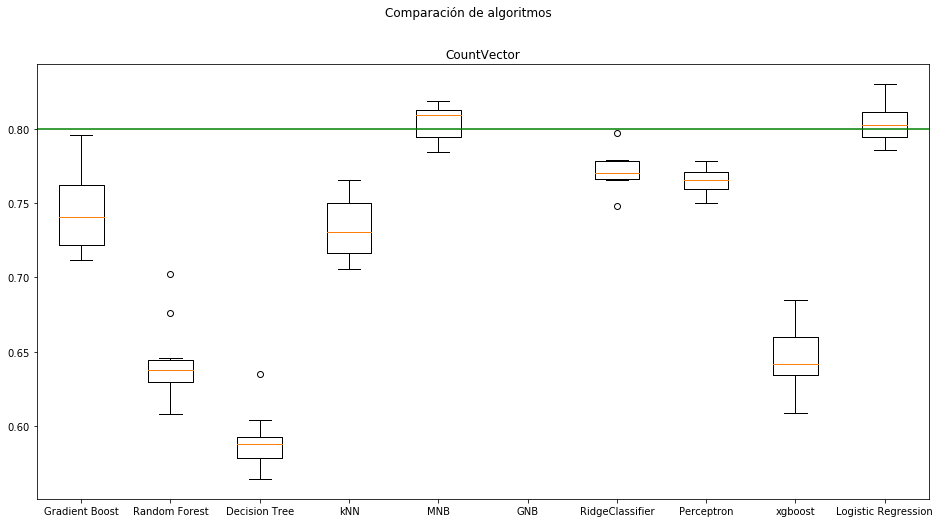

In [71]:
modelsDict = {    
    "Gradient Boost": modelGB["Count Vector"],
    "Random Forest": modelRF["Count Vector"],
    "Decision Tree": modelDT["Universal sentence encoder"],
    "kNN": modelKNN["Count Vector"],
    'MNB': modelMNB["Count Vector"],
    'GNB': modelGNB["Count Vector"],
    'RidgeClassifier': modelRC["Count Vector"],
    'Perceptron': modelPE["Count Vector"],
    'xgboost': modelXG["Count Vector"],
    "Logistic Regression":modelLR["Count Vector"] 
    }
graph_classifier(x_train_cv, y_train_cv,"CountVector",modelsDict)

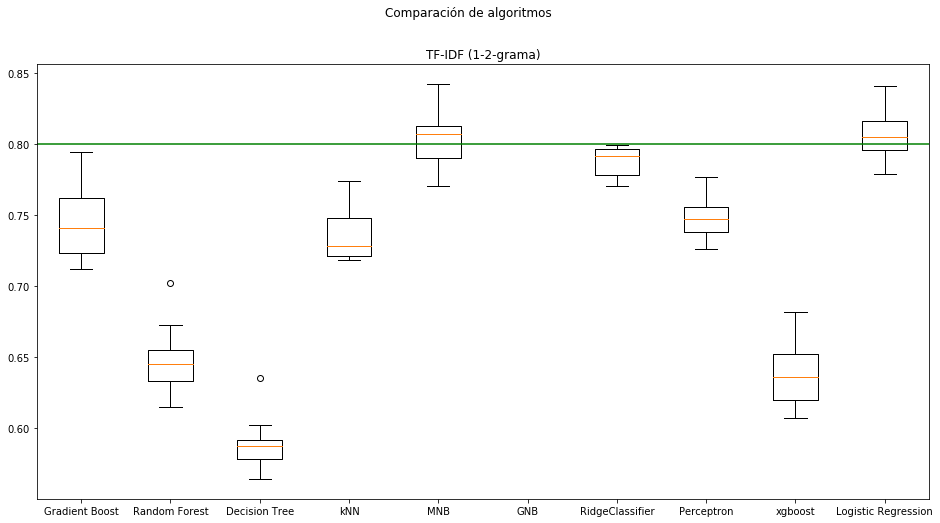

In [72]:
#Datos para TF-IDF
modelsDict = {
    "Gradient Boost": modelGB["TF-IDF"],
    "Random Forest": modelRF["TF-IDF"],
    "Decision Tree": modelDT["Universal sentence encoder"],
    "kNN": modelKNN["TF-IDF"],
    'MNB': modelMNB["TF-IDF"],
    'GNB': modelGNB["TF-IDF"],
    'RidgeClassifier': modelRC["TF-IDF"],
    'Perceptron': modelPE["TF-IDF"],
    'xgboost': modelXG["TF-IDF"],
    "Logistic Regression":modelLR["TF-IDF"] 
    }
graph_classifier(x_train_tf, y_train_tf,"TF-IDF (1-2-grama)",modelsDict)

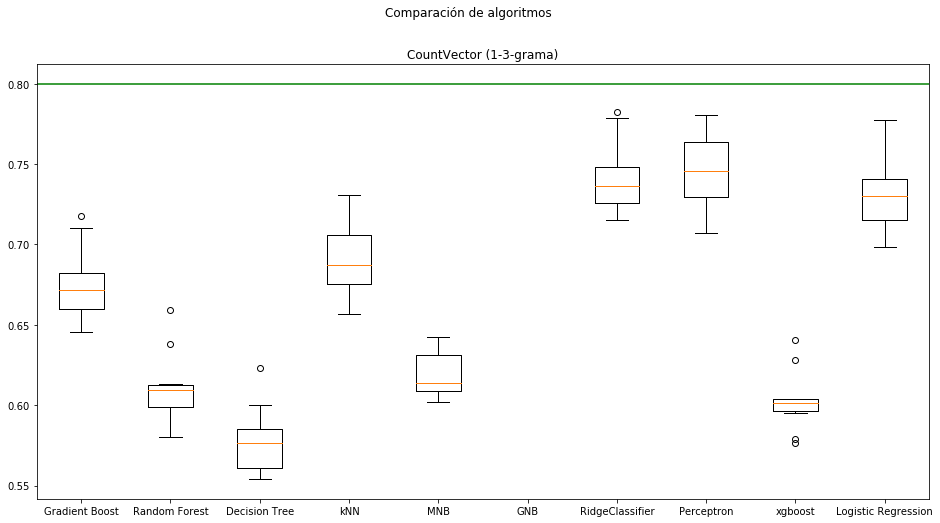

In [73]:
#Datos para countVector + n-gramas
modelsDict = {    
    "Gradient Boost": modelGB["Count Vector + ng"],
    "Random Forest": modelRF["Count Vector + ng"],
    "Decision Tree": modelDT["Universal sentence encoder"],
    "kNN": modelKNN["Count Vector + ng"],
    'MNB': modelMNB["Count Vector + ng"],
    'GNB': modelGNB["Count Vector + ng"],
    'RidgeClassifier': modelRC["Count Vector + ng"],
    'Perceptron': modelPE["Count Vector + ng"],
    'xgboost': modelXG["Count Vector + ng"],
    "Logistic Regression":modelLR["Count Vector + ng"] 
    }
graph_classifier(x_train_ng_cv, y_train_ng_cv,"CountVector (1-3-grama)",modelsDict)

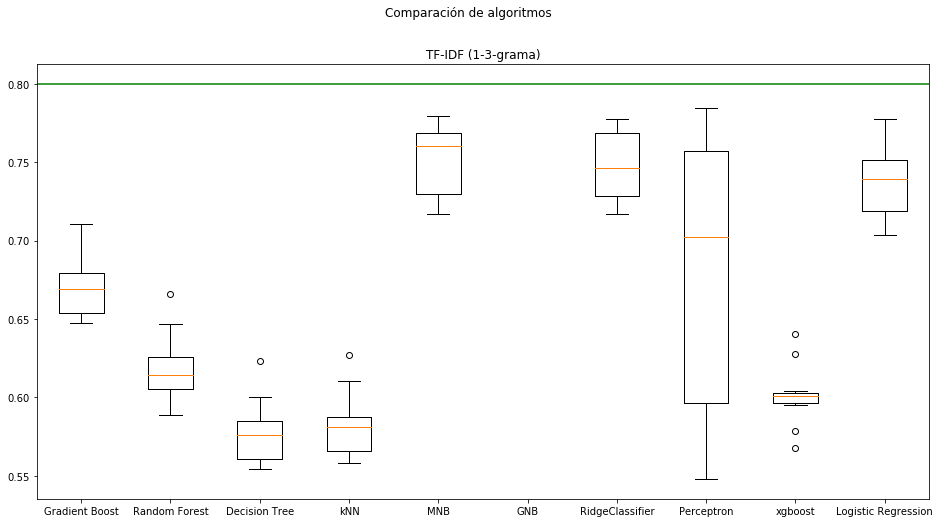

In [74]:
#Datos para TF-IDF ngramas
modelsDict = {    
    "Gradient Boost": modelGB["TF-IDF + ng"],
    "Random Forest": modelRF["TF-IDF + ng"],
    "Decision Tree": modelDT["Universal sentence encoder"],
    "kNN": modelKNN["TF-IDF + ng"],
    'MNB': modelMNB["TF-IDF + ng"],
    'GNB': modelGNB["TF-IDF + ng"],
    'RidgeClassifier': modelRC["TF-IDF + ng"],
    'Perceptron': modelPE["TF-IDF + ng"],
    'xgboost': modelXG["TF-IDF + ng"],
    "Logistic Regression":modelLR["TF-IDF + ng"] 
    }
graph_classifier(x_train_ng_tf, y_train_ng_tf,"TF-IDF (1-3-grama)",modelsDict)

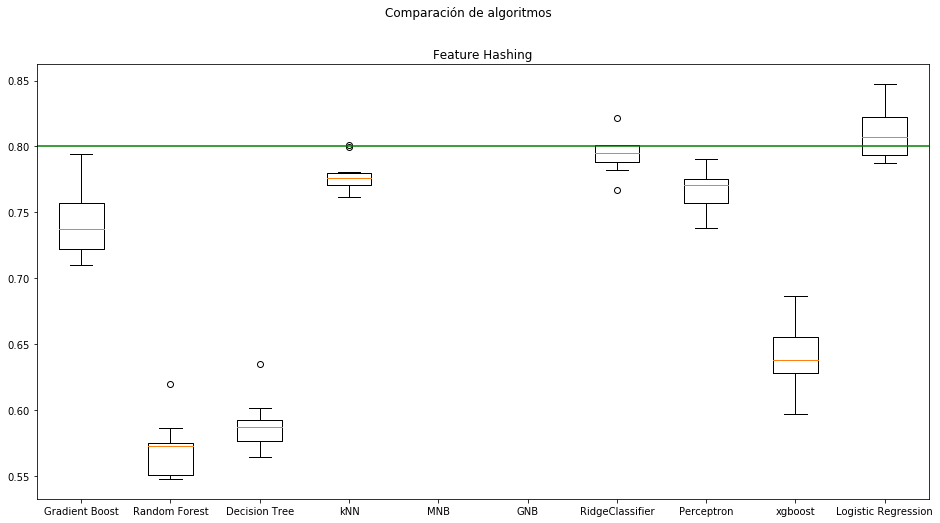

In [75]:
#Datos para Feature Hashing
modelsDict = {    
   "Gradient Boost": modelGB["Feature Hashing"],
    "Random Forest": modelRF["Feature Hashing"],
    "Decision Tree": modelDT["Universal sentence encoder"],
    "kNN": modelKNN["Feature Hashing"],
    'MNB': modelMNB["Feature Hashing"],
    'GNB': modelGNB["Feature Hashing"],
    'RidgeClassifier': modelRC["Feature Hashing"],
    'Perceptron': modelPE["Feature Hashing"],
    'xgboost': modelXG["Feature Hashing"],
    "Logistic Regression":modelLR["Feature Hashing"] 
    }
graph_classifier(x_train_fh, y_train_fh,"Feature Hashing",modelsDict)

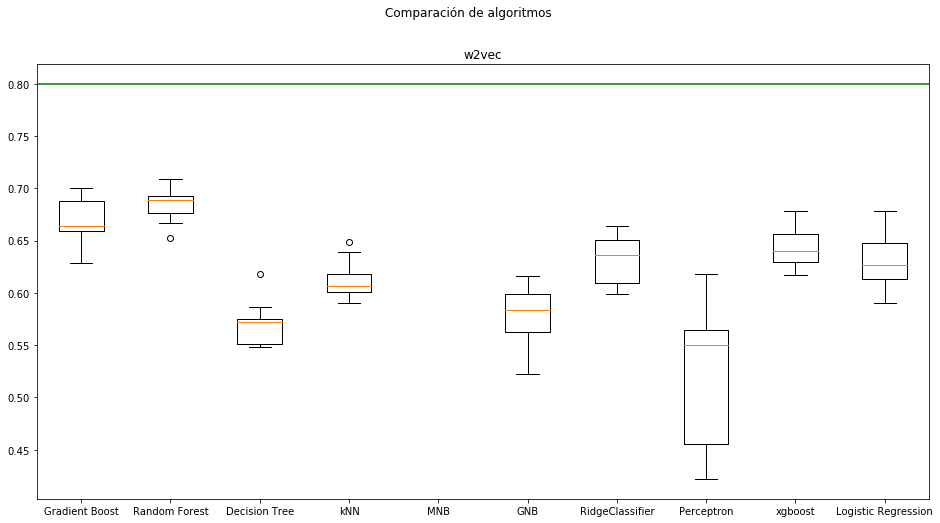

In [76]:
#Datos para w2vec
modelsDict = {    
   "Gradient Boost": modelGB["Word2Vec"],
    "Random Forest": modelRF["Word2Vec"],
    "Decision Tree": modelDT["Universal sentence encoder"],
    "kNN": modelKNN["Word2Vec"],
    'MNB': modelMNB["Word2Vec"],
    'GNB': modelGNB["Word2Vec"],
    'RidgeClassifier': modelRC["Word2Vec"],
    'Perceptron': modelPE["Word2Vec"],
    'xgboost': modelXG["Word2Vec"],
    "Logistic Regression":modelLR["Word2Vec"] 
    }
graph_classifier(x_train_w2vec, y_train_w2vec,"w2vec",modelsDict)

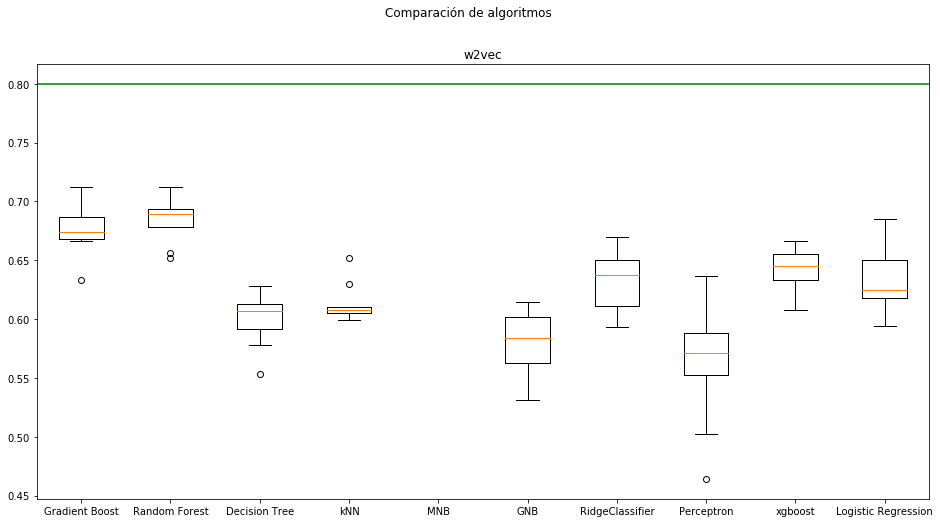

In [77]:
#Datos para w2vec+tfid
modelsDict = {    
   "Gradient Boost": modelGB["Word2Vec + TF-IDF"],
    "Random Forest": modelRF["Word2Vec + TF-IDF"],
    "Decision Tree": modelDT["Universal sentence encoder"],
    "kNN": modelKNN["Word2Vec + TF-IDF"],
    'MNB': modelMNB["Word2Vec + TF-IDF"],
    'GNB': modelGNB["Word2Vec + TF-IDF"],
    'RidgeClassifier': modelRC["Word2Vec + TF-IDF"],
    'Perceptron': modelPE["Word2Vec + TF-IDF"],
    'xgboost': modelXG["Word2Vec + TF-IDF"],
    "Logistic Regression":modelLR["Word2Vec + TF-IDF"] 
    }
graph_classifier(x_train_w2vecTfid, y_train_w2vecTfid,"w2vec",modelsDict)

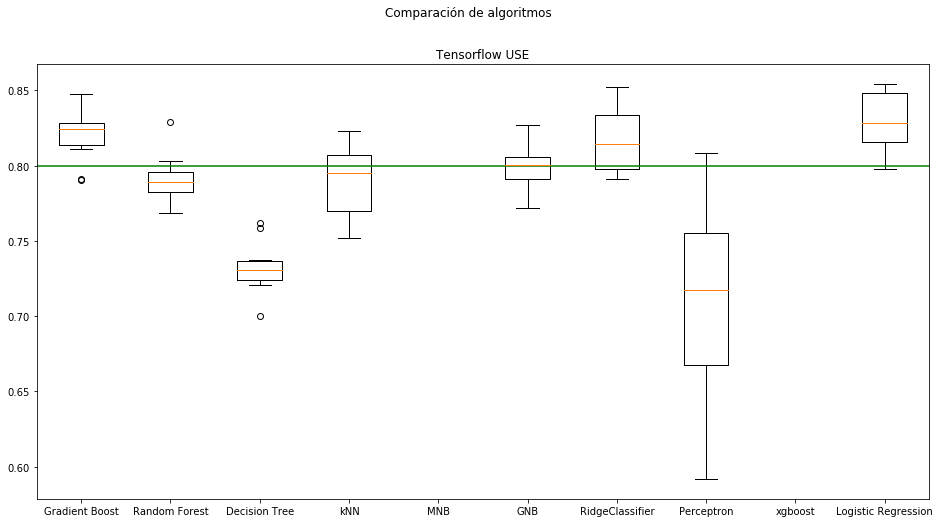

In [78]:
#Datos para Tensorflor universal setence encode
modelsDict = {    
   "Gradient Boost": modelGB["Universal sentence encoder"],
    "Random Forest": modelRF["Universal sentence encoder"],
    "Decision Tree": modelDT["Universal sentence encoder"],
    "kNN": modelKNN["Universal sentence encoder"],
    'MNB': modelMNB["Universal sentence encoder"],
    'GNB': modelGNB["Universal sentence encoder"],
    'RidgeClassifier': modelRC["Universal sentence encoder"],
    'Perceptron': modelPE["Universal sentence encoder"],
    'xgboost': modelXG["Universal sentence encoder"],
    "Logistic Regression":modelLR["Universal sentence encoder"] 
    }
graph_classifier(x_train_usetf, y_train_usetf,"Tensorflow USE",modelsDict)

# 7. Envío de datos
Preparo el submit

In [346]:
def submission(model,test_vector):
    
    '''Input- model=final fit model to be used for predictions
              test_vector=pre-processed and vectorized test dataset
       Output- submission file in .csv format with predictions       
    
    '''    
    sub_df = pd.read_csv('../data/sample_submission.csv')
    sub_df["target"] = model.predict(test_vector)
    sub_df.to_csv("submission.csv", index=False)
        

In [347]:
#MNB + countVector
mnb_model = MultinomialNB()
mnb_model.fit(x_train_cv, y_train_cv)
submission(mnb_model,test_cv)

In [348]:
#Logistic Regression +TF-IDF (1-2-gramas)
lr_model = LogisticRegression(C=1.0)
lr_model.fit(x_train_tf, y_train_tf)
submission(lr_model,test_tf)

In [349]:
#MNB + TF-IDF (1-2-gramas)
mnb_model = MultinomialNB()
mnb_model.fit(x_train_tf, y_train_tf)
submission(mnb_model,test_tf)

In [ ]:
# TensorFlow + RandomForest (0.80324)
trf_model = modelsDict["Random Forest"]
trf_model.fit(x_train_usetf,y_train_usetf)
submission(trf_model,test_use_tf)

In [351]:
# TensorFlow + Knn (0.78884)
tknn_model = modelsDict["kNN"]
tknn_model.fit(x_train_usetf,y_train_usetf)
submission(tknn_model,test_use_tf)

In [ ]:
# TensorFlow + Ridge (0.79221)
trid_model = modelsDict["RidgeClassifier"]
trid_model.fit(x_train_usetf,y_train_usetf)
submission(trid_model,test_use_tf)

In [ ]:
# TensorFlow + Logistic Reg (0.80416)
tlr_model = modelsDict["Logistic Regression"]
tlr_model.fit(x_train_usetf,y_train_usetf)
submission(tlr_model,test_use_tf)

In [ ]:
# Randomforest + Hiperparams
hip_model = modelsDict["RandomForest up"]
hip_model.fit(x_train_usetf,y_train_usetf)
submission(hip_model,test_use_tf)

In [352]:
# Tensorflor --- logistic + Hyper (0.80876)
lrh_model = LogisticRegression(C=0.615848211066026, solver='liblinear')
lrh_model.fit(x_train_usetf,y_train_usetf)
submission(lrh_model,test_use_tf)

In [353]:
#TENSORFLOW --- gradient boost Hyper TEXT + KEYWORD + SENTIMENT (0.82010) ... (0.82347) eliminando las filas con textos duplicados y distinto target
x_train_usetf_sen, x_test_usetf_sen, y_train_usetf_sen, y_test_usetf_sen = train_test_split(train_use_tf2_s,tweets_train.target,test_size=0.2,random_state=2020)

sen_model = GradientBoostingClassifier(learning_rate=0.0055, max_depth=2, max_features=27,
                           min_samples_leaf=23, n_estimators=4850,
                           random_state=2020, subsample=0.86)
sen_model.fit(x_train_usetf_sen, y_train_usetf_sen)
submission(sen_model,test_use_tf2_s)

In [302]:
#Sentiment + RandomForest (0.77001)
sen_model = RandomForestClassifier(max_depth=4, max_features=110, min_samples_leaf=50,
                       min_samples_split=7, n_estimators=1350)
sen_model.fit(x_train_usetf_sen, y_train_usetf_sen)
submission(sen_model,test_use_tf2_s)

## Anexo: otras pruebas realizadas

### Conv1d

Pruebas Hiper parametros

In [61]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(tf.keras.layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [63]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100

# Train-test split
sentences_train, sentences_test, y_train, y_test = train_test_split(train_df2["text"],tweets_train.target, test_size=0.25, random_state=1000)

# Tokenize words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [64]:
# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size],
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=10, verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 26.8min finished


In [65]:
# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)
s = ('Best Accuracy : '
     '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
output_string = s.format(grid_result.best_score_,grid_result.best_params_,test_accuracy)
print(output_string)

Best Accuracy : 0.7686
{'vocab_size': 12341, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.7714




In [66]:
#create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen)
model_keras_hyper = create_model(32, 5, 12341, 50, 100)
history_conv_hyper = model_keras_hyper.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=False)
loss, accuracy = model_keras_hyper.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_keras_hyper.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9952
Testing Accuracy:  0.7840


El siguiente submit dio score de 0.76555 en kaggle

In [67]:
# make a prediction
predict_sequences = tokenizer.texts_to_sequences(test_df2["text"])

# Padding
predict_padded = pad_sequences(predict_sequences, padding='post', maxlen=maxlen)
y_pred_hyper = model_keras_hyper.predict_classes(predict_padded)

y_conv1d_pred = [y_pred_hyper[i][0] for i in range(len(y_pred_hyper))]
sub_df = pd.read_csv('../data/sample_submission.csv')
sub_df["target"] = y_conv1d_pred
#sub_df.to_csv("submission_conv1d_hyper.csv", index=False)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
